# Exploratory analysis of Ames housing dataset

In a [previous notebook](process.ipynb/#Processing-the-Ames-housing-dataset), we processed and cleaned the Ames housing dataset. In this notebook, we focus on exploring the variables and the relationships among them. In a [later notebook](model.ipynb/#Modeling-and-predicting-SalePrice) we'll model and predict sale prices.

## Setup

In [45]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import scipy.stats as ss
import sys
import os

# add parent directory for importing custom classes
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(pardir)

# add root site-packages directory to workaround pyitlib pip install issue
sys.path.append('/Users/home/anaconda3/lib/python3.7/site-packages')

# custom classes
from codes.process import DataDescription, HPDataFramePlus, DataPlus
from codes.explore import *

warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')

## Load and inspect data

In [58]:
data_dir = '../data'
file_names = ['orig.csv', 'clean.csv']
hp_data = load_datasets(data_dir, file_names)
orig, clean = (hp_data.dfs['orig'], hp_data.dfs['clean'])                                    

We have 2 versions of the dataset here (created in [a previous notebook](preprocess.ipynb/#Preprocessing-the-Ames-housing-dataset))

- `orig` is the original dataset with no preprocessing
- `clean` is the preprocessed dataset, with problematic variables and observations dropped and missing values imputed

. In this notebook we'll primarily be working with the cleaned dataset

In [59]:
clean.data.head()

MSSubClass MSZoning  LotFrontage  LotArea Street  LotShape  \
      Id                                                              
train 1          60       RL         65.0   8450.0   Pave         0   
      2          20       RL         80.0   9600.0   Pave         0   
      3          60       RL         68.0  11250.0   Pave         1   
      4          70       RL         60.0   9550.0   Pave         1   
      5          60       RL         84.0  14260.0   Pave         1   

         LandContour  Utilities LotConfig  LandSlope  ... ScreenPorch  \
      Id                                              ...               
train 1          Lvl          3    Inside          0  ...         0.0   
      2          Lvl          3       FR2          0  ...         0.0   
      3          Lvl          3    Inside          0  ...         0.0   
      4          Lvl          3    Corner          0  ...         0.0   
      5          Lvl          3       FR2          0  ...         0.0   

         PoolArea PoolQC Fence MiscVal  MoSold  YrSold  SaleType  \
      Id                                                           
train 1       0.0      0     0     0.0       2    2008        WD   
      2       0.0      0     0     0.0       5    2007        WD   
      3       0.0      0     0     0.0       9    2008        WD   
      4       0.0      0     0     0.0       2    2006        WD   
      5       0.0      0     0     0.0      12    2008        WD   

          SaleCondition SalePrice  
      Id                           
train 1          Normal  208500.0  
      2          Normal  181500.0  
      3          Normal  223500.0  
      4         Abnorml  140000.0  
      5          Normal  250000.0  

[5 rows x 78 columns]

In [60]:
clean.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Data columns (total 78 columns):
MSSubClass       2916 non-null category
MSZoning         2916 non-null category
LotFrontage      2916 non-null float64
LotArea          2916 non-null float64
Street           2916 non-null category
LotShape         2916 non-null int64
LandContour      2916 non-null category
Utilities        2916 non-null int64
LotConfig        2916 non-null category
LandSlope        2916 non-null int64
Neighborhood     2916 non-null category
Condition1       2916 non-null category
Condition2       2916 non-null category
BldgType         2916 non-null category
HouseStyle       2916 non-null category
OverallQual      2916 non-null int64
OverallCond      2916 non-null int64
YearBuilt        2916 non-null float64
YearRemodAdd     2916 non-null float64
RoofStyle        2916 non-null category
RoofMatl         2916 non-null category
Exterior1st      2916 non-null category
Exterior2nd    

## The response variable `SalePrice`

First let's look at the distribution of `SalePrice`, the variable we'll later be interested in predicting.

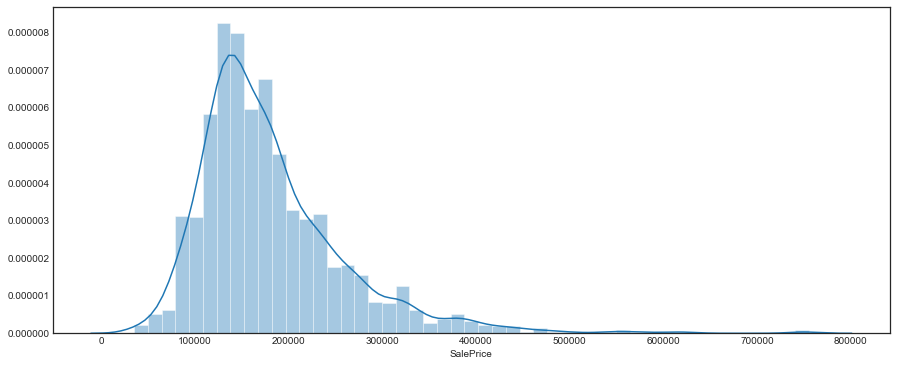

In [7]:
sale_price = clean.data.loc['train', :]['SalePrice']
plt.figure(figsize=(15, 6))
sns.distplot(sale_price)

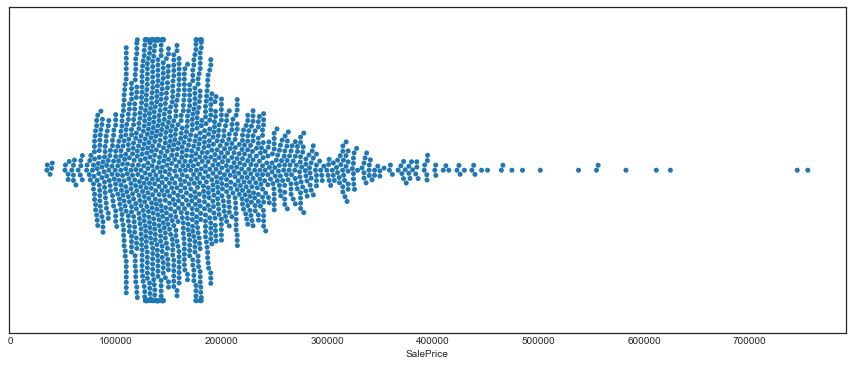

In [8]:
plt.figure(figsize=(15, 6))
sns.swarmplot(sale_price)

The distribution is positively skewed, with a long right tail. There are two observations with `SalePrice` > 700000, and with a good separation from the rest of the points.

In [9]:
# check skewness of SalePrice
sale_price.skew()

1.88374941136315

### Testing log-normality

The distribution looks like it may be approximately log-normal, let's check this

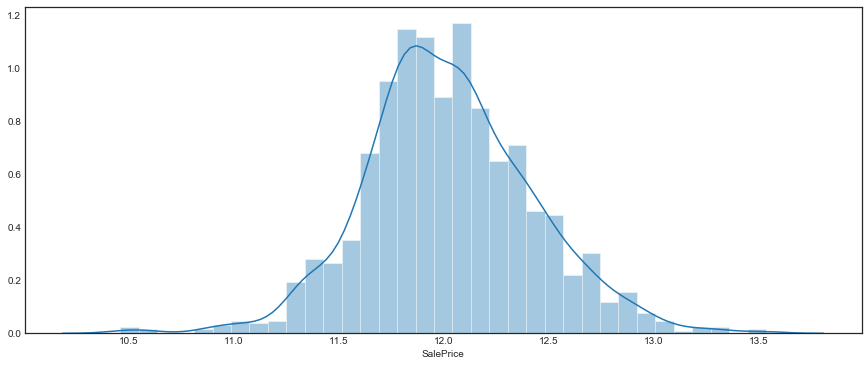

In [10]:
# distribution of log(SalePrice)
plt.figure(figsize=(15, 6))
sns.distplot(np.log(sale_price))

#### QQ-plot

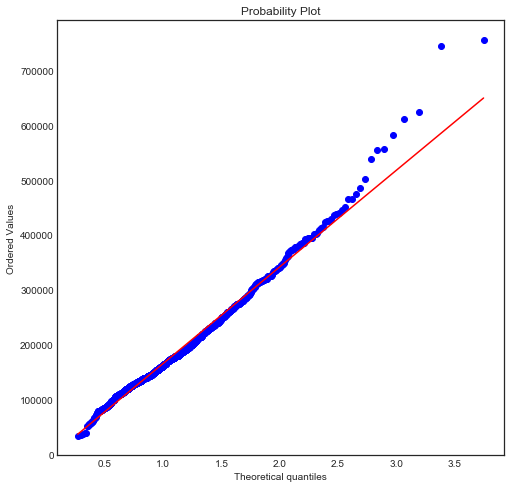

In [16]:
# lognormal QQ plot
plt.figure(figsize=(8, 8))
# standard deviation of log is the shape parameter
s = np.log(sale_price).std()
lognorm = ss.lognorm(s)
ss.probplot(sale_price, dist=lognorm, plot=plt)
plt.show()

The distribution appears to be approxiately log-normal, although the QQ plot shows the right tail is a bit longer than expected, and the two observations with highest `SalePrice` are much higher than expected.

#### Kolmogorov - Smirnov test

This is a [non-parametric test for comparing distributions](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test). We'll use `scipy.stats` [implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html)

In [17]:
ss.kstest(sale_price, lognorm.cdf)

KstestResult(statistic=1.0, pvalue=0.0)

This test conclusively rejects the null hypothesis that the distribution of `SalePrice` is lognormal. Nevertheless, the plots indicate that log-normality is perhaps a usefull approximation. Moreover, `log(SalePrice)` may be more useful than `SalePrice` for prediction purposes, given the symmetry of its distribution.

## Categorical variables

First we look at all categorical variables, that is, all discrete variables with no ordering on the values. In our cleaned dataframe these are all the columns with `category` dtype

In [18]:
# dataframe of categorical variables
cats = HPDataFramePlus(data=clean.data.select_dtypes('category'))
cats.data.head()

MSSubClass MSZoning Street LandContour LotConfig Neighborhood  \
      Id                                                                 
train 1          60       RL   Pave         Lvl    Inside      CollgCr   
      2          20       RL   Pave         Lvl       FR2      Veenker   
      3          60       RL   Pave         Lvl    Inside      CollgCr   
      4          70       RL   Pave         Lvl    Corner      Crawfor   
      5          60       RL   Pave         Lvl       FR2      NoRidge   

         Condition1 Condition2 BldgType HouseStyle  ... Exterior1st  \
      Id                                            ...               
train 1        Norm       Norm     1Fam     2Story  ...     VinylSd   
      2       Feedr       Norm     1Fam     1Story  ...     MetalSd   
      3        Norm       Norm     1Fam     2Story  ...     VinylSd   
      4        Norm       Norm     1Fam     2Story  ...     Wd Sdng   
      5        Norm       Norm     1Fam     2Story  ...     VinylSd   

         Exterior2nd MasVnrType Foundation Heating CentralAir Electrical  \
      Id                                                                   
train 1      VinylSd    BrkFace      PConc    GasA          Y      SBrkr   
      2      MetalSd       None     CBlock    GasA          Y      SBrkr   
      3      VinylSd    BrkFace      PConc    GasA          Y      SBrkr   
      4      Wd Shng       None     BrkTil    GasA          Y      SBrkr   
      5      VinylSd    BrkFace      PConc    GasA          Y      SBrkr   

         GarageType SaleType SaleCondition  
      Id                                    
train 1      Attchd       WD        Normal  
      2      Attchd       WD        Normal  
      3      Attchd       WD        Normal  
      4      Detchd       WD       Abnorml  
      5      Attchd       WD        Normal  

[5 rows x 22 columns]

In [14]:
# print description of categorical variables
desc = DataDescription('../data/data_description.txt')
cats.desc = desc
cats.print_desc(cols=cats.data.columns)

MSSubClass: Identifies the type of dwelling involved in the sale.

	 20 - 1-STORY 1946 & NEWER ALL STYLES
	 30 - 1-STORY 1945 & OLDER
	 40 - 1-STORY W/FINISHED ATTIC ALL AGES
	 45 - 1-1/2 STORY - UNFINISHED ALL AGES
	 50 - 1-1/2 STORY FINISHED ALL AGES
	 60 - 2-STORY 1946 & NEWER
	 70 - 2-STORY 1945 & OLDER
	 75 - 2-1/2 STORY ALL AGES
	 80 - SPLIT OR MULTI-LEVEL
	 85 - SPLIT FOYER
	 90 - DUPLEX - ALL STYLES AND AGES
	 120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
	 150 - 1-1/2 STORY PUD - ALL AGES
	 160 - 2-STORY PUD - 1946 & NEWER
	 180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
	 190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES


MSZoning: Identifies the general zoning classification of the sale.

	 A - Agriculture
	 C - Commercial
	 FV - Floating Village Residential
	 I - Industrial
	 RH - Residential High Density
	 RL - Residential Low Density
	 RP - Residential Low Density Park 
	 RM - Residential Medium Density


Street: Type of road access to property

	 Grvl - Grave

### Distributions

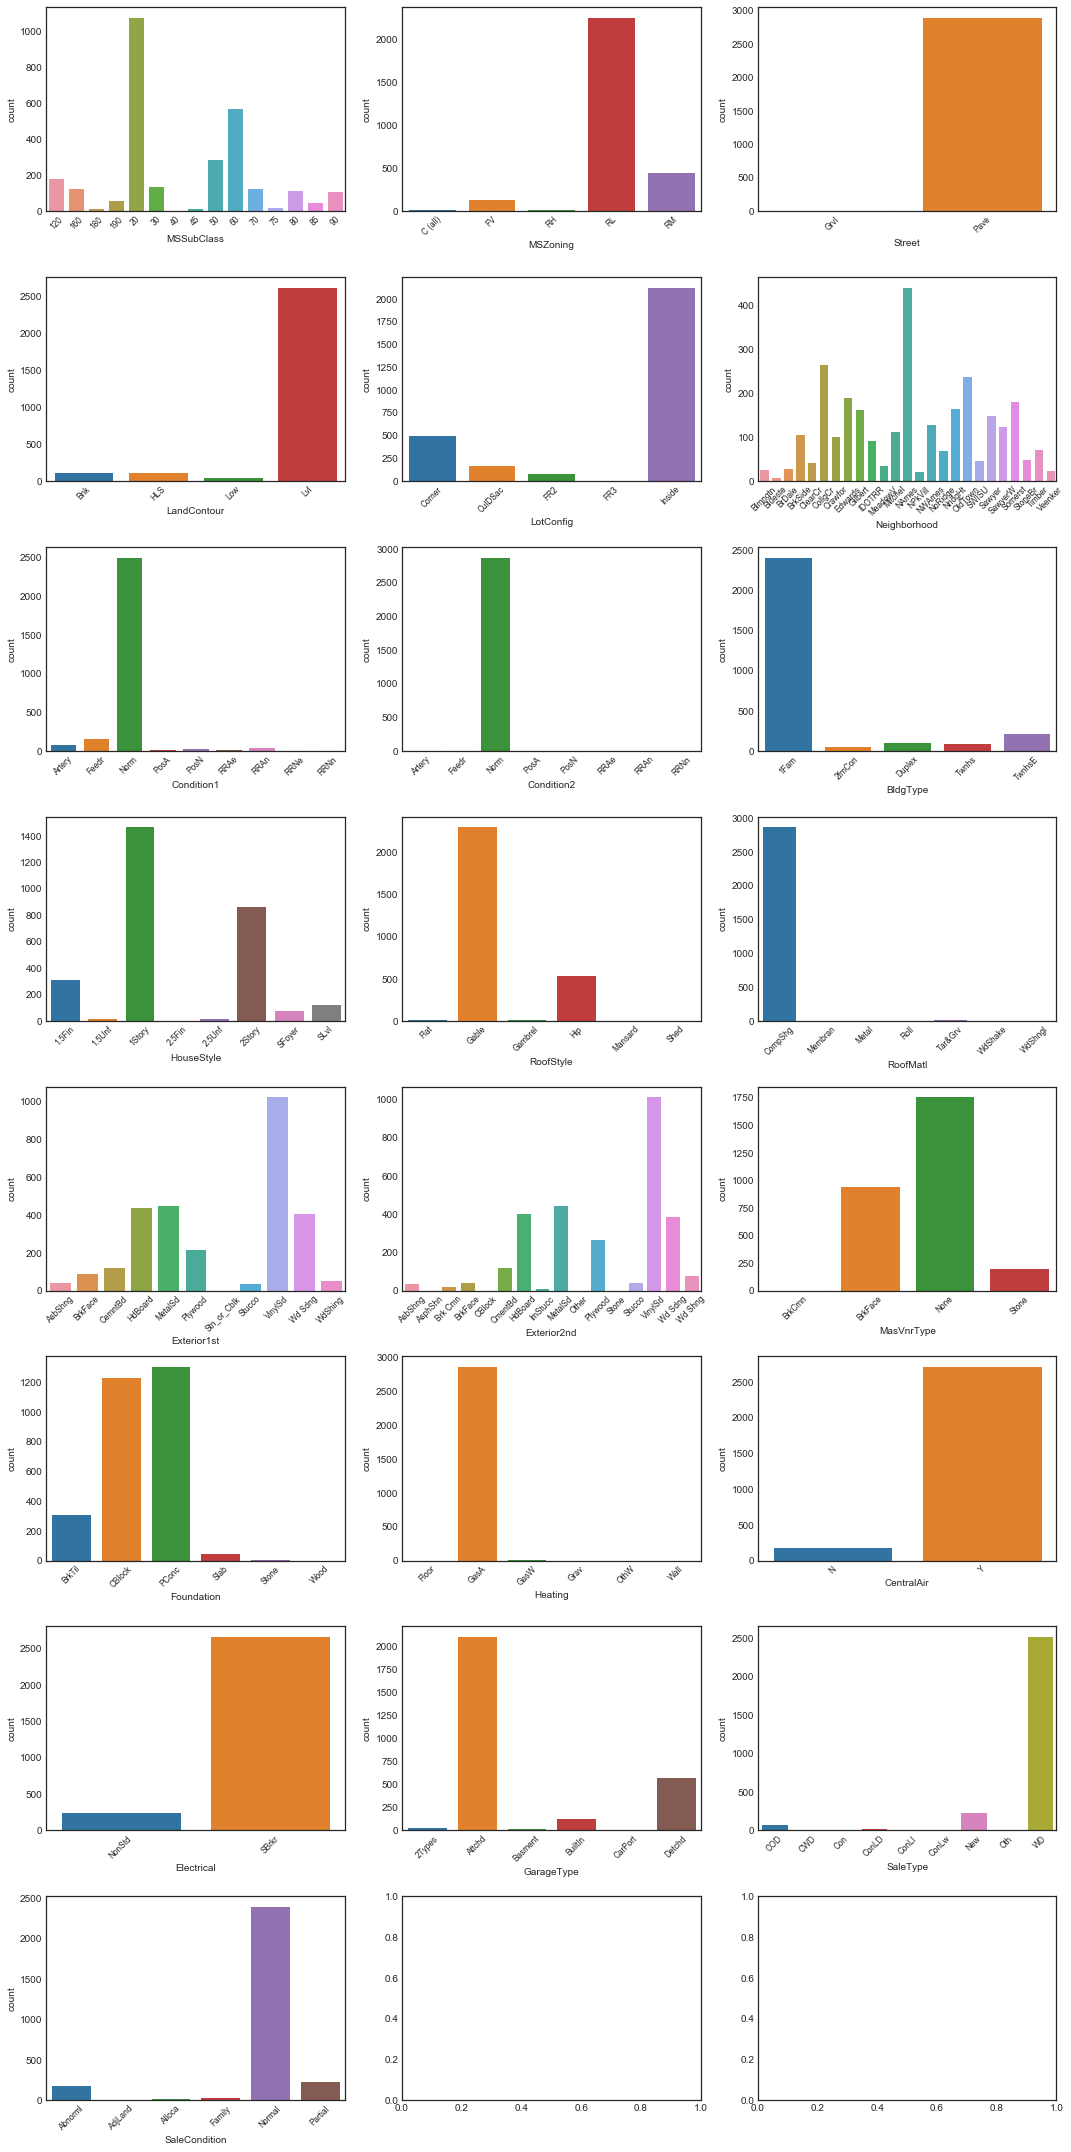

In [19]:
# plot distributions of categorical variables
plot_discrete_dists(nrows=8, ncols=3, data=cats.data)

Some of these variables have highly unbalanced distributions. We'll look for the most extremely unbalanced

In [20]:
# print distributions of categorical variables with more 90% concentration at single value
unbal_cat_cols = print_unbal_dists(data=cats.data, bal_threshold=0.9)


Pave    0.995885
Grvl    0.004115
Name: Street, dtype: float64

Norm      0.990055
Feedr     0.004458
Artery    0.001715
PosA      0.001372
PosN      0.001029
RRNn      0.000686
RRAn      0.000343
RRAe      0.000343
Name: Condition2, dtype: float64

CompShg    0.985940
Tar&Grv    0.007545
WdShake    0.003086
WdShngl    0.002401
Roll       0.000343
Metal      0.000343
Membran    0.000343
Name: RoofMatl, dtype: float64

GasA     0.984568
GasW     0.009259
Grav     0.003086
Wall     0.002058
OthW     0.000686
Floor    0.000343
Name: Heating, dtype: float64

Y    0.932785
N    0.067215
Name: CentralAir, dtype: float64

SBrkr     0.915295
NonStd    0.084705
Name: Electrical, dtype: float64


### Relationships among categorical variables

One often speaks loosely of "correlation" among variables to refer to statistical dependence. There are various measures of dependence, but here we rely on an information theoretic measure known as the [variation of information](https://en.wikipedia.org/wiki/Variation_of_information). We discuss this measure briefly

The function

$$d(X, Y) = H(X, Y) - I(X, Y)$$

where $H(X, Y)$ is the joint entropy and $I(X, Y)$ the mutual information, [defines a metric](https://arxiv.org/pdf/q-bio/0311039.pdf) on the set of random variables. Note that

$$d(X, Y) = H(X|Y) + H(Y|X)$$

which is sometimes called the "variation of information". One can normalize to get a standardized variation of information

$$D(X, Y) = \frac{d(X, Y)}{H(X, Y)} = 1 - \frac{I(X, Y)}{H(X, Y)} $$

i.e. $D(X, Y) \in [0, 1]$. Since $D$ is a metric, $D(X, Y) = 0$ iff $X = Y$ Furthermore, $D(X, Y) = 1$ if and only if $I(X, Y) = 0$ if and only if $X, Y$ are independendent. So we can take $D(X, Y)$ as a "dependence distance". The closer a variable $Y$ is to $X$, the more it depends on $X$.

We rely on the Python package `pyitlib` to compute $D(X, Y)$.

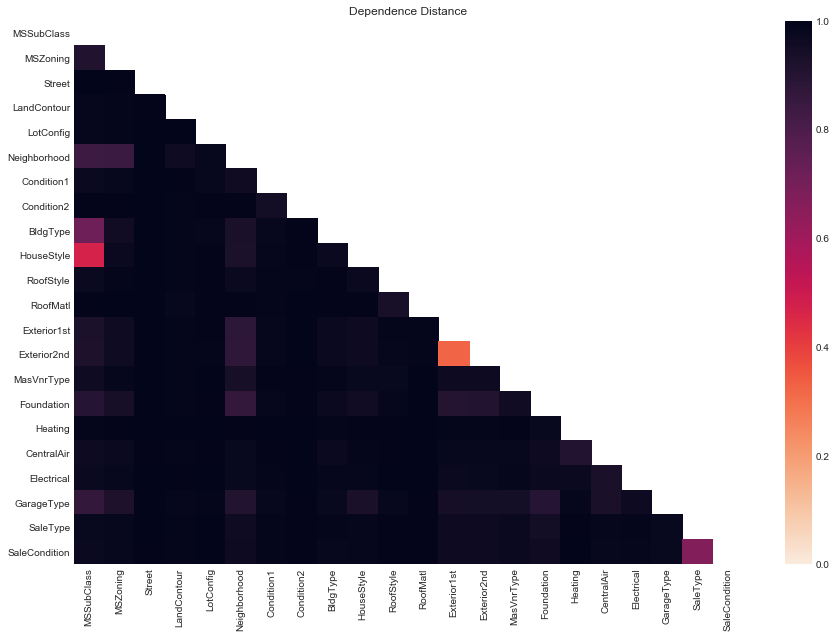

In [21]:
# plot dependence distance of categorical variables
cats_data_num = num_enc(data=cats.data)
cats_D_dep_df = D_dep(data=cats_data_num)
plot_D_dep(cats_D_dep_df)

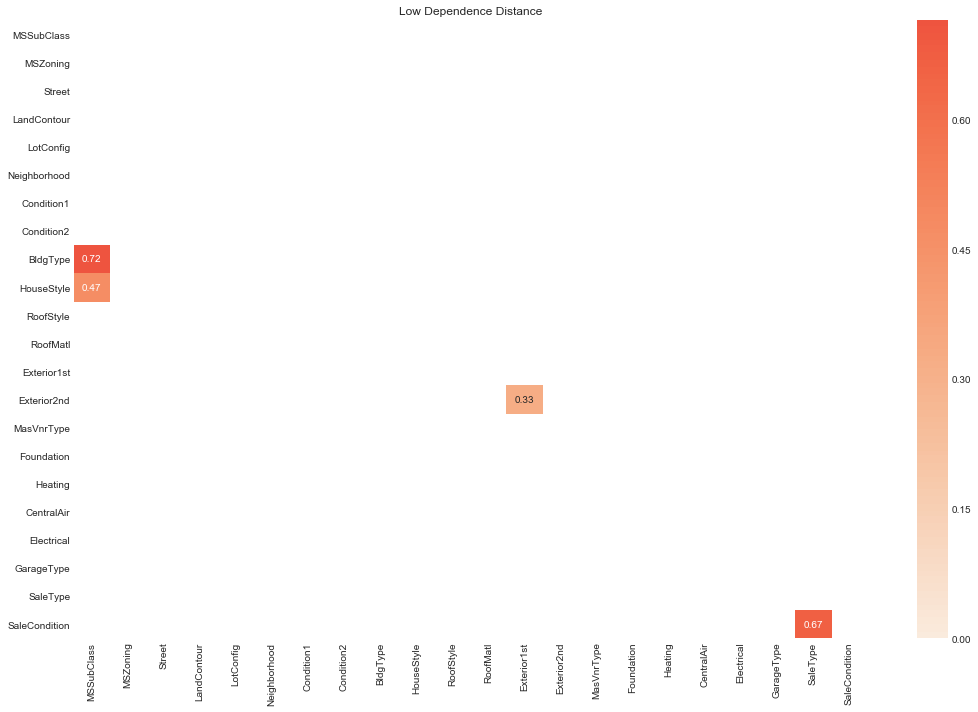

In [22]:
# plot dependence distances less than 0.8
plot_low_D_dep(D_dep_df=cats_D_dep_df, D_threshold=0.8)

In [23]:
# rank categorical variables by dependence distance
rank_pairs_by_D(D_dep_df=cats_D_dep_df, D_threshold=0.8)

var1           var2         D
1  Exterior1st    Exterior2nd  0.326878
2   MSSubClass     HouseStyle  0.472106
3     SaleType  SaleCondition  0.667950
4   MSSubClass       BldgType  0.715326

 Notable pairs of distinct variables with low information distance are
 
- `Exterior1st` and `Exterior2nd` have the lowest dependence distance ($D \approx 0.322$). Their distributions are very similar and they have the same values. It probably makes more sense to think of them as close to identically distributed. 
- `MSSubclass` and `HouseStyle` have the next lowest ($D \approx 0.47$). Inspecting their descriptions above we see that they have very similar categories, so they are measuring very similar things. `BldgType` and `MSSubclass` ($D \approx 0.71$) are similar. 
- `MSSubclass` and `Neighborhood` ($D \approx 0.84$) are perhaps the first interesting pair in that they are measuring different things. We can imagine that the association between these two variables is strong -- it makes sense that the size/age/type of house would be associated to the neighborhood. Similarly, `Exterior1st`, `Exterior2nd`, `MSZoning`, `Foundation` also have strong associations with `Neighborhood`.
- `SaleCondition` and `SaleType` ($D \approx 0.67$) are also unsurprisingly associated. 

### Relationships between categoricals and `SalePrice`

Given that `SalePrice` seemed to be [well-approximated](#Testing-log-normality) by a log-normal distribution, we'll measure dependence with `log_SalePrice`.

In [24]:
cats_data_num['log_SalePrice'] = np.log(clean.data['SalePrice'])
cats_data_num['log_SalePrice']

       Id  
train  1       12.247694
       2       12.109011
       3       12.317167
       4       11.849398
       5       12.429216
                 ...    
test   2915          NaN
       2916          NaN
       2917          NaN
       2918          NaN
       2919          NaN
Name: log_SalePrice, Length: 2916, dtype: float64

To visualize the relationship between the categorical variables and the response, we'll look at the distributions of `log_SalePrice` over the values of the variables.

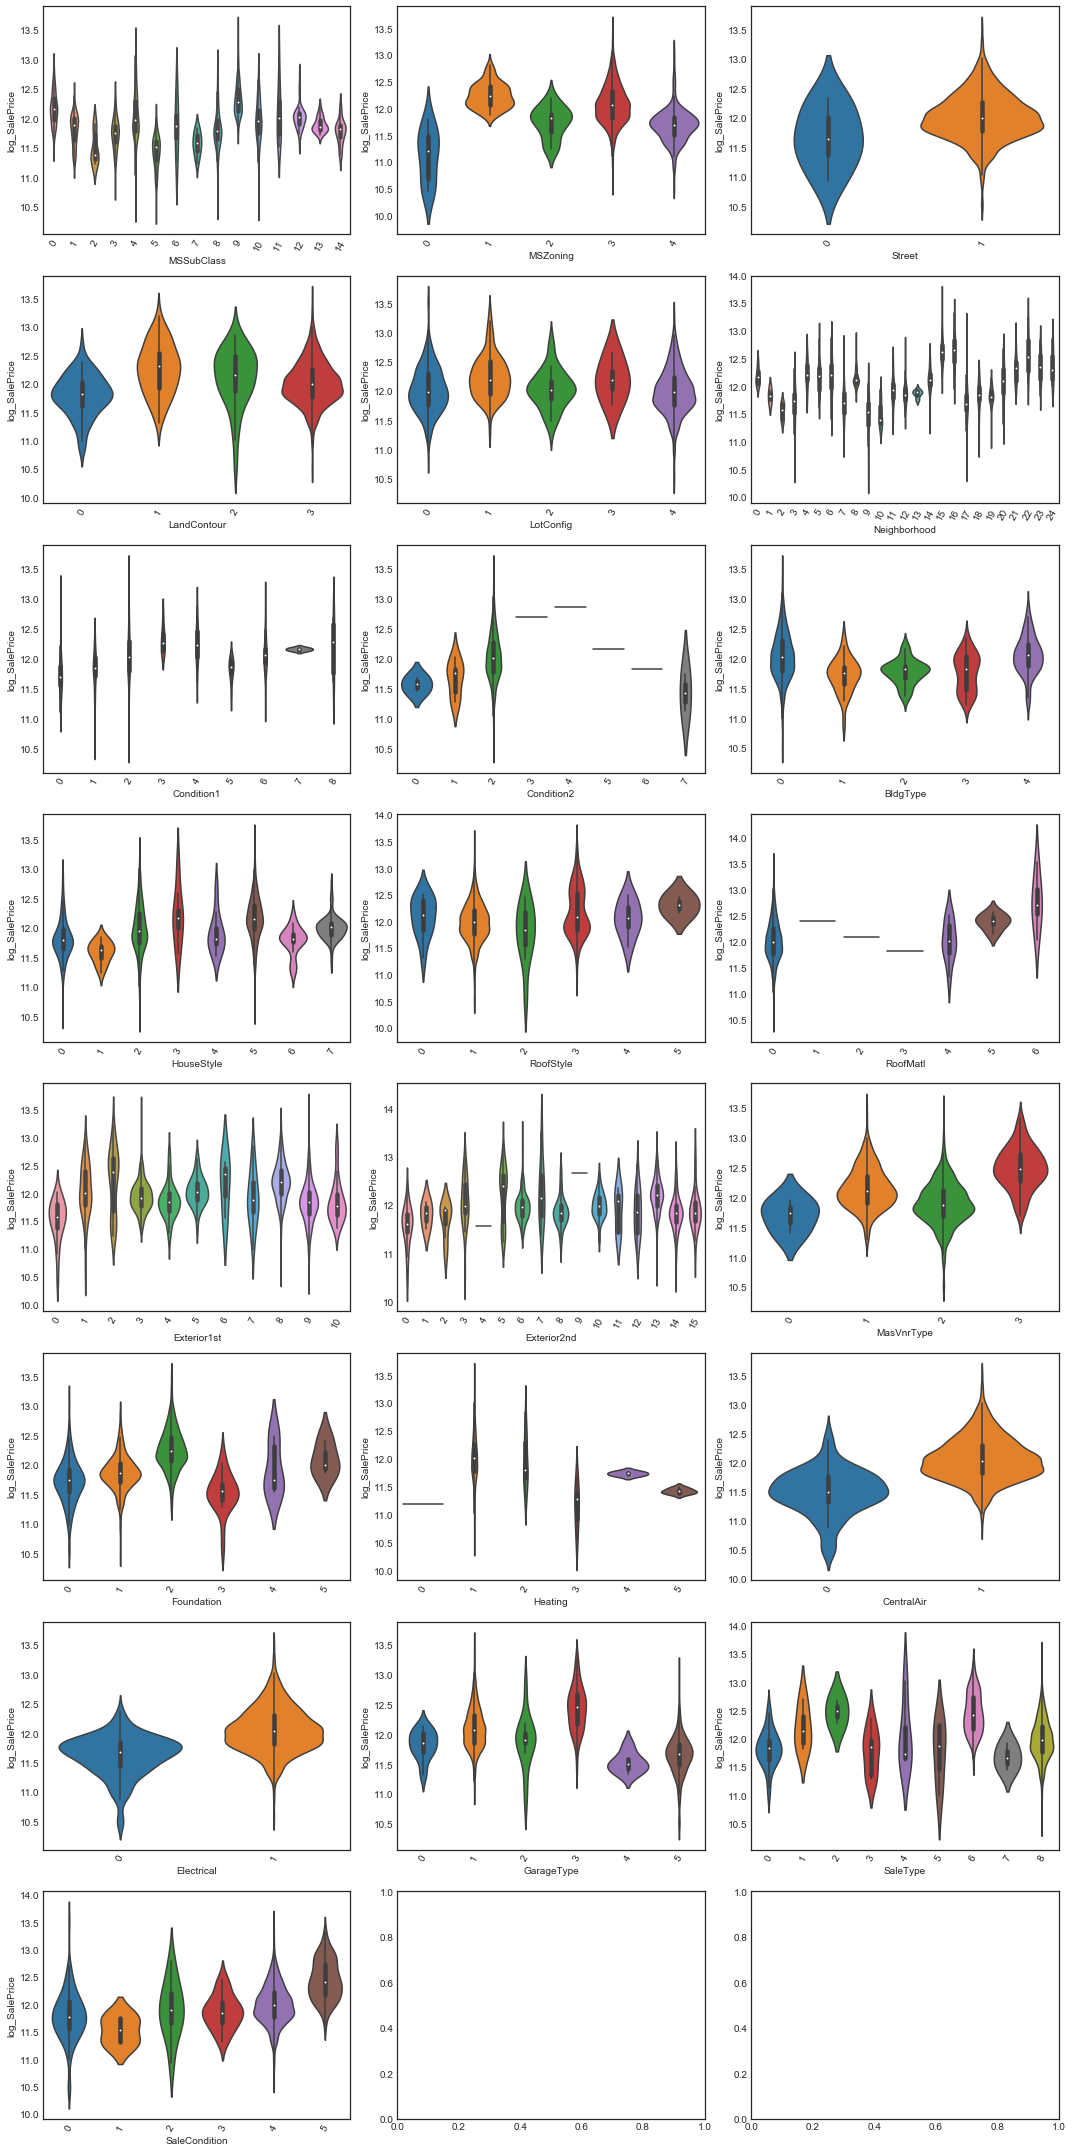

In [25]:
# violin plots of categorical variables vs. response
plot_violin_plots(data=cats_data_num, response='log_SalePrice', nrows=8, ncols=3)

Note that horizontal lines for variable values in the violin plots indicate <5 observations having that value

From these plots, it's difficult to determine with accuracy for which variables the distribution of `log_SalePrice` doesn't seem to vary greatly across values. (and hence are of low dependence and hence low predictive value). The dependence distance between the variables and `log_SalePrice` will provide additional information.

In [26]:
# rank categorical variables by dependence distance from response
D_dep_response(cats_data_num, 'log_SalePrice').sort_values(by='D').T

Neighborhood MSSubClass Exterior2nd Exterior1st HouseStyle Foundation  \
D     0.713181   0.813621    0.831957    0.840524   0.894477   0.901514   

  GarageType MasVnrType SaleCondition LotConfig  ... Condition1  BldgType  \
D   0.919312   0.924422      0.926004  0.929782  ...   0.937908  0.938181   

  RoofStyle LandContour Electrical CentralAir   Heating  RoofMatl Condition2  \
D  0.947682    0.956498   0.973275   0.973683  0.990074  0.990213   0.991566   

     Street  
D  0.996507  

[1 rows x 22 columns]

The lower the dependence distance here, the better assocation with the response, hence the better potential predictive value.

In particular, given how unbalanced their distributions are, it's perhaps not too surprising to see `RoofStyle`, `LandContour`, `Electrical` and `CentralAir` all have such high dependence distance, 

## Ordinal variables

Now we'll investigate ordinal variables, that is discrete variables with an ordering. In our cleaned dataframe these are variables with `int64` dtype

In [27]:
# dataframe of ordinal variables
ords = HPDataFramePlus(data=clean.data.select_dtypes('int64'))
ords.data.head()

LotShape  Utilities  LandSlope  OverallQual  OverallCond  ExterQual  \
      Id                                                                        
train 1          0          3          0            7            5          2   
      2          0          3          0            6            8          1   
      3          1          3          0            7            5          2   
      4          1          3          0            7            5          1   
      5          1          3          0            8            5          2   

          ExterCond  BsmtQual  BsmtCond  BsmtExposure  ...  GarageCars  \
      Id                                               ...               
train 1           3         3         3             1  ...           2   
      2           3         3         3             4  ...           2   
      3           3         3         3             2  ...           2   
      4           3         2         4             1  ...           3   
      5           3         3         3             3  ...           3   

          GarageQual  GarageCond  PavedDrive  PoolQC  Fence  MoSold  YrSold  \
      Id                                                                      
train 1            3           3           2       0      0       2    2008   
      2            3           3           2       0      0       5    2007   
      3            3           3           2       0      0       9    2008   
      4            3           3           2       0      0       2    2006   
      5            3           3           2       0      0      12    2008   

          Bath  BsmtBath  
      Id                  
train 1      5         2  
      2      4         1  
      3      5         2  
      4      2         2  
      5      5         2  

[5 rows x 31 columns]

In [28]:
ords.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Data columns (total 31 columns):
LotShape        2916 non-null int64
Utilities       2916 non-null int64
LandSlope       2916 non-null int64
OverallQual     2916 non-null int64
OverallCond     2916 non-null int64
ExterQual       2916 non-null int64
ExterCond       2916 non-null int64
BsmtQual        2916 non-null int64
BsmtCond        2916 non-null int64
BsmtExposure    2916 non-null int64
BsmtFinType1    2916 non-null int64
BsmtFinType2    2916 non-null int64
HeatingQC       2916 non-null int64
BedroomAbvGr    2916 non-null int64
KitchenAbvGr    2916 non-null int64
KitchenQual     2916 non-null int64
TotRmsAbvGrd    2916 non-null int64
Functional      2916 non-null int64
Fireplaces      2916 non-null int64
FireplaceQu     2916 non-null int64
GarageFinish    2916 non-null int64
GarageCars      2916 non-null int64
GarageQual      2916 non-null int64
GarageCond      2916 non-null int64
PavedDrive  

We'll print the description of all variables, however note that the print description contains the original value for the variables, while the cleaned dataframe `clean` contains the [numerically encoded values](preprocess.ipynb/#Encode-variables)

In [29]:
# print description of ordinal variables
ords.desc = desc
ords.print_desc(cols=ords.data.columns)

LotShape: General shape of property

	 Reg - Regular
	 IR1 - Slightly irregular
	 IR2 - Moderately Irregular
	 IR3 - Irregular


Utilities: Type of utilities available

	 AllPub - All public Utilities (E,G,W,& S)
	 NoSewr - Electricity, Gas, and Water (Septic Tank)
	 NoSeWa - Electricity and Gas Only
	 ELO - Electricity only


LandSlope: Slope of property

	 Gtl - Gentle slope
	 Mod - Moderate Slope
	 Sev - Severe Slope


OverallQual: Rates the overall material and finish of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


OverallCond: Rates the overall condition of the house

	 10 - Very Excellent
	 9 - Excellent
	 8 - Very Good
	 7 - Good
	 6 - Above Average
	 5 - Average
	 4 - Below Average
	 3 - Fair
	 2 - Poor
	 1 - Very Poor


ExterQual: Evaluates the quality of the material on the exterior 

	 Ex - Excellent
	 Gd - Good
	 TA - Average/Typical
	 Fa - Fair
	 Po 

### Distributions

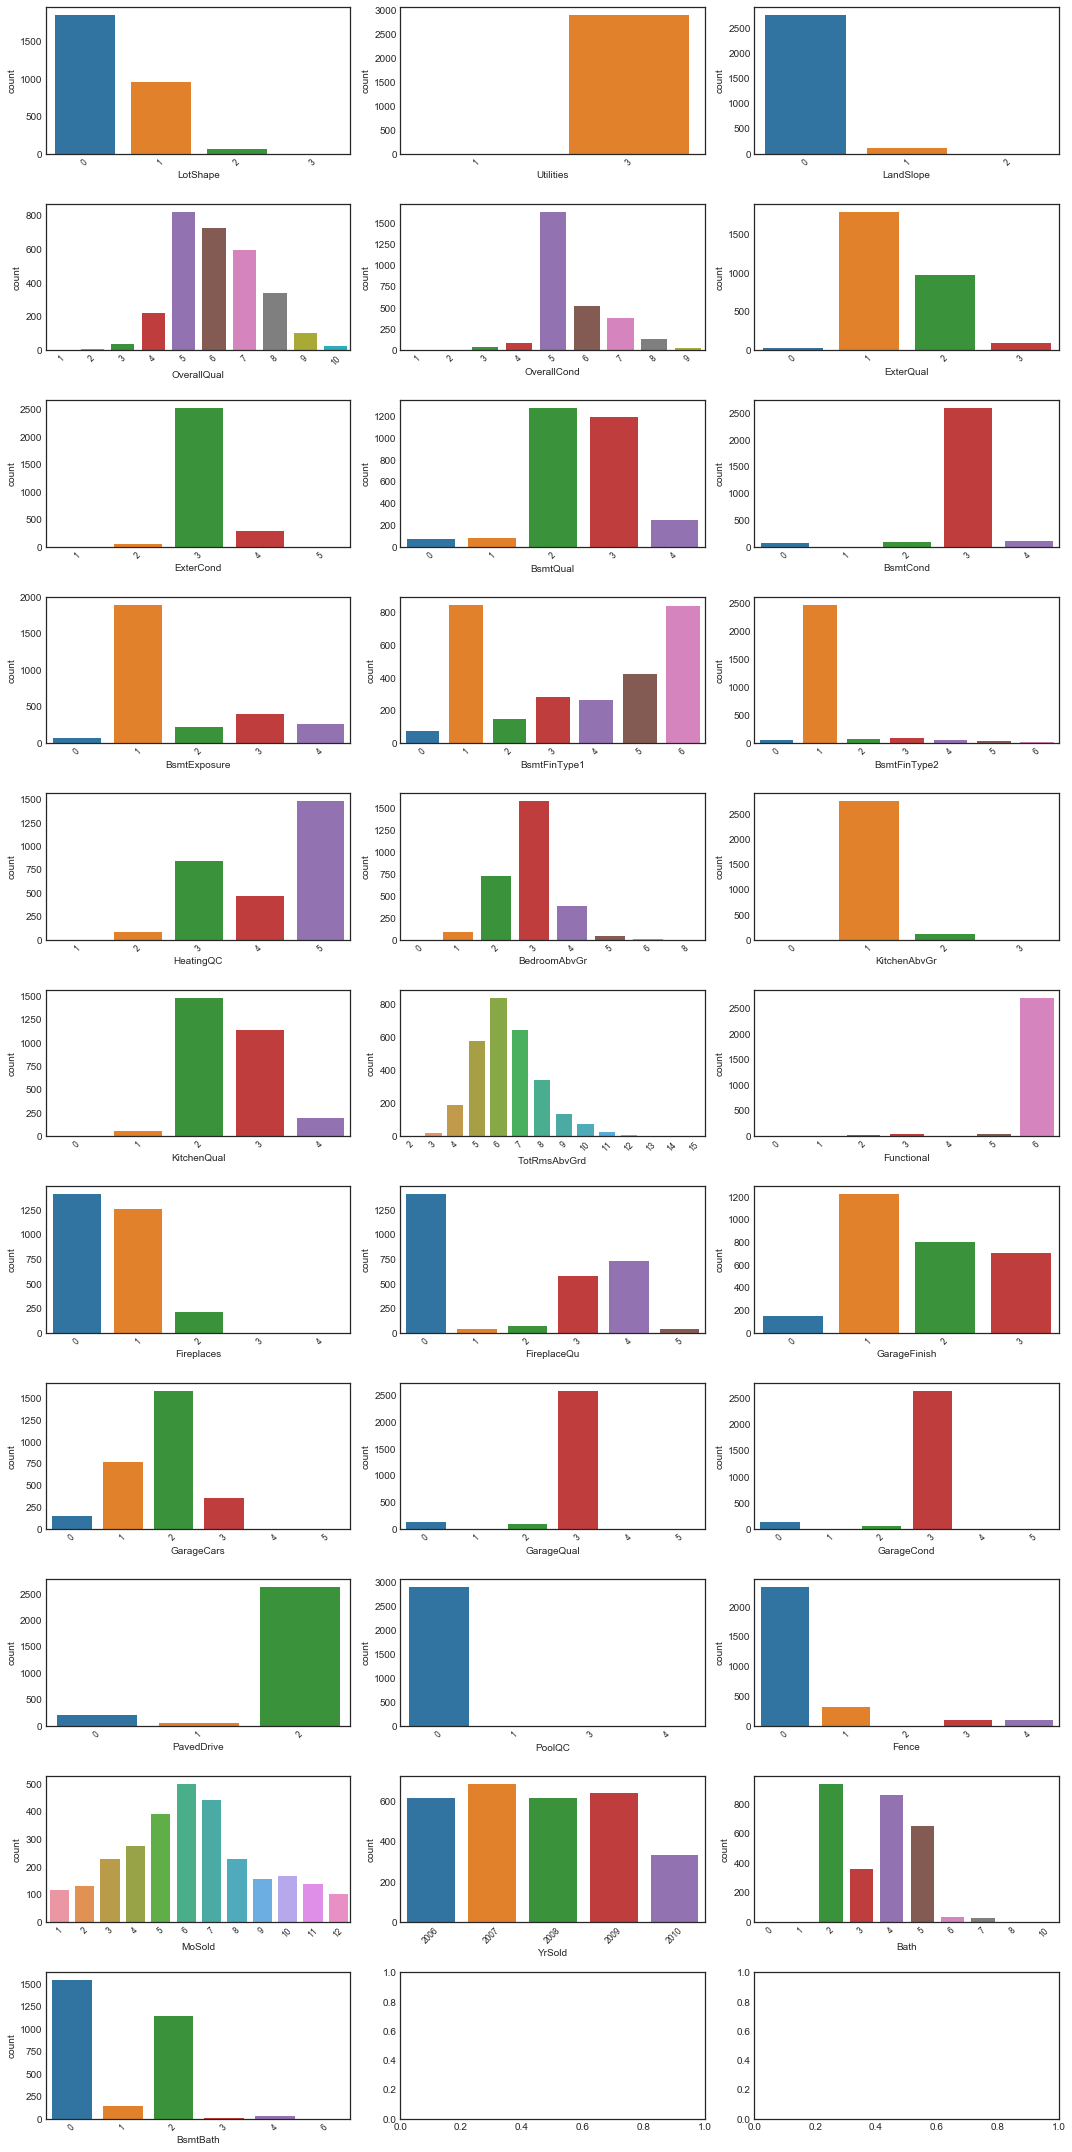

In [30]:
# plot distributions of ordinal variables
plot_discrete_dists(nrows=11, ncols=3, data=ords.data)

In [31]:
# look at most unbalanced distributions
unbal_ord_cols = print_unbal_dists(data=ords.data, bal_threshold=0.9)


3    0.999657
1    0.000343
Name: Utilities, dtype: float64

0    0.951989
1    0.042524
2    0.005487
Name: LandSlope, dtype: float64

1    0.954047
2    0.044239
0    0.001029
3    0.000686
Name: KitchenAbvGr, dtype: float64

6    0.931756
3    0.024005
5    0.021948
2    0.012003
4    0.006516
1    0.003086
0    0.000686
Name: Functional, dtype: float64

3    0.909122
0    0.054527
2    0.025377
4    0.005144
1    0.004801
5    0.001029
Name: GarageCond, dtype: float64

2    0.904664
0    0.074074
1    0.021262
Name: PavedDrive, dtype: float64

0    0.996914
4    0.001372
3    0.001029
1    0.000686
Name: PoolQC, dtype: float64


### Relationships among ordinal variables

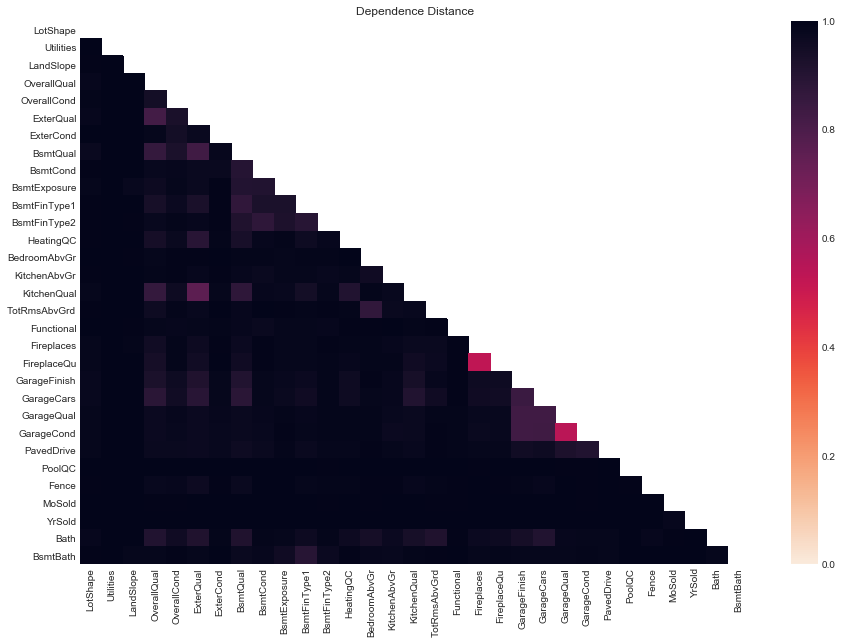

In [32]:
# plot dependence distances of ordinal variables
ords_D_dep_df = D_dep(ords.data)
plot_D_dep(ords_D_dep_df)

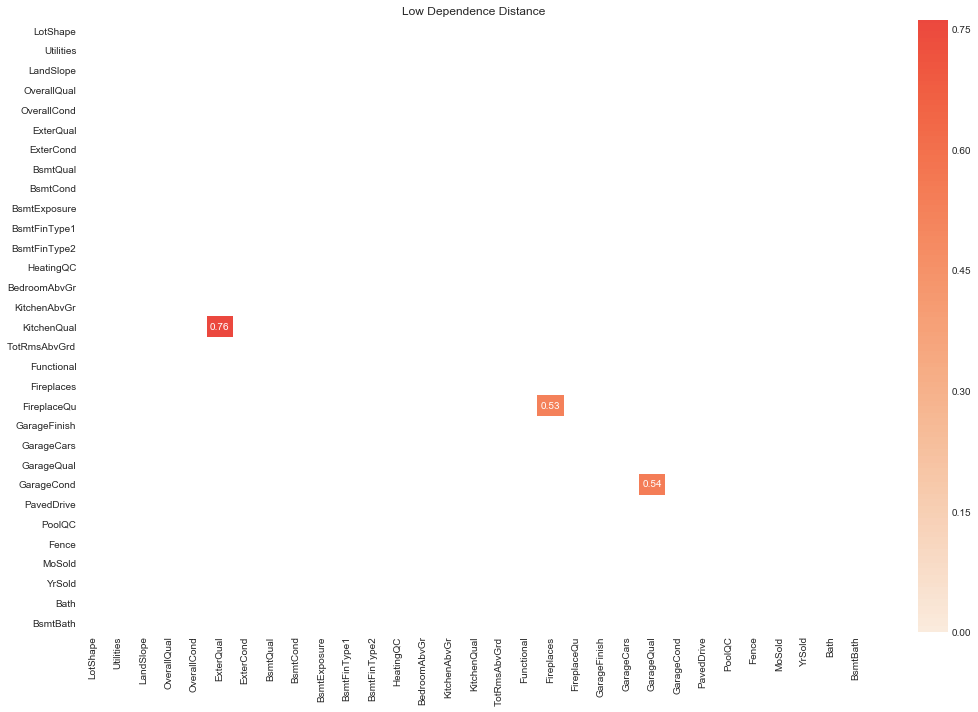

In [34]:
# plot lower dependence distances of ordinal variables
plot_low_D_dep(D_dep_df=ords_D_dep_df, D_threshold=0.8)

In [35]:
# rank ordinals by low dependence distance
rank_pairs_by_D(D_dep_df=ords_D_dep_df, D_threshold=0.8)

var1         var2         D
1  Fireplaces  FireplaceQu  0.528211
2  GarageQual   GarageCond  0.542600
3   ExterQual  KitchenQual  0.760176

 Notable pairs of distinct ordinal variables with low information distance are
 
- `Fireplaces` and `FireplaceQu` have the lowest dependence distance ($D \approx 0.53$). This is somewhat interesting, in that the quantities these variables are measuring are distinct (albeit related).
- `GarageQual` and `GarageCond` have the next lowest ($D \approx 0.54$). Inspecting their descriptions above we see that they have very similar categories, so they are measuring very similar things. There is ostensibly a distinction between the quality of the garage and its condition, however.
- Pairs of garage variables display relatively low dependence distance, as do pairs of basement variables and quality variables.

### Relationships between ordinals and `SalePrice`

In [36]:
# add log_SalePrice to ordinal dataframe
ords.data['log_SalePrice'] = np.log(clean.data['SalePrice'])
ords.data['log_SalePrice']

       Id  
train  1       12.247694
       2       12.109011
       3       12.317167
       4       11.849398
       5       12.429216
                 ...    
test   2915          NaN
       2916          NaN
       2917          NaN
       2918          NaN
       2919          NaN
Name: log_SalePrice, Length: 2916, dtype: float64

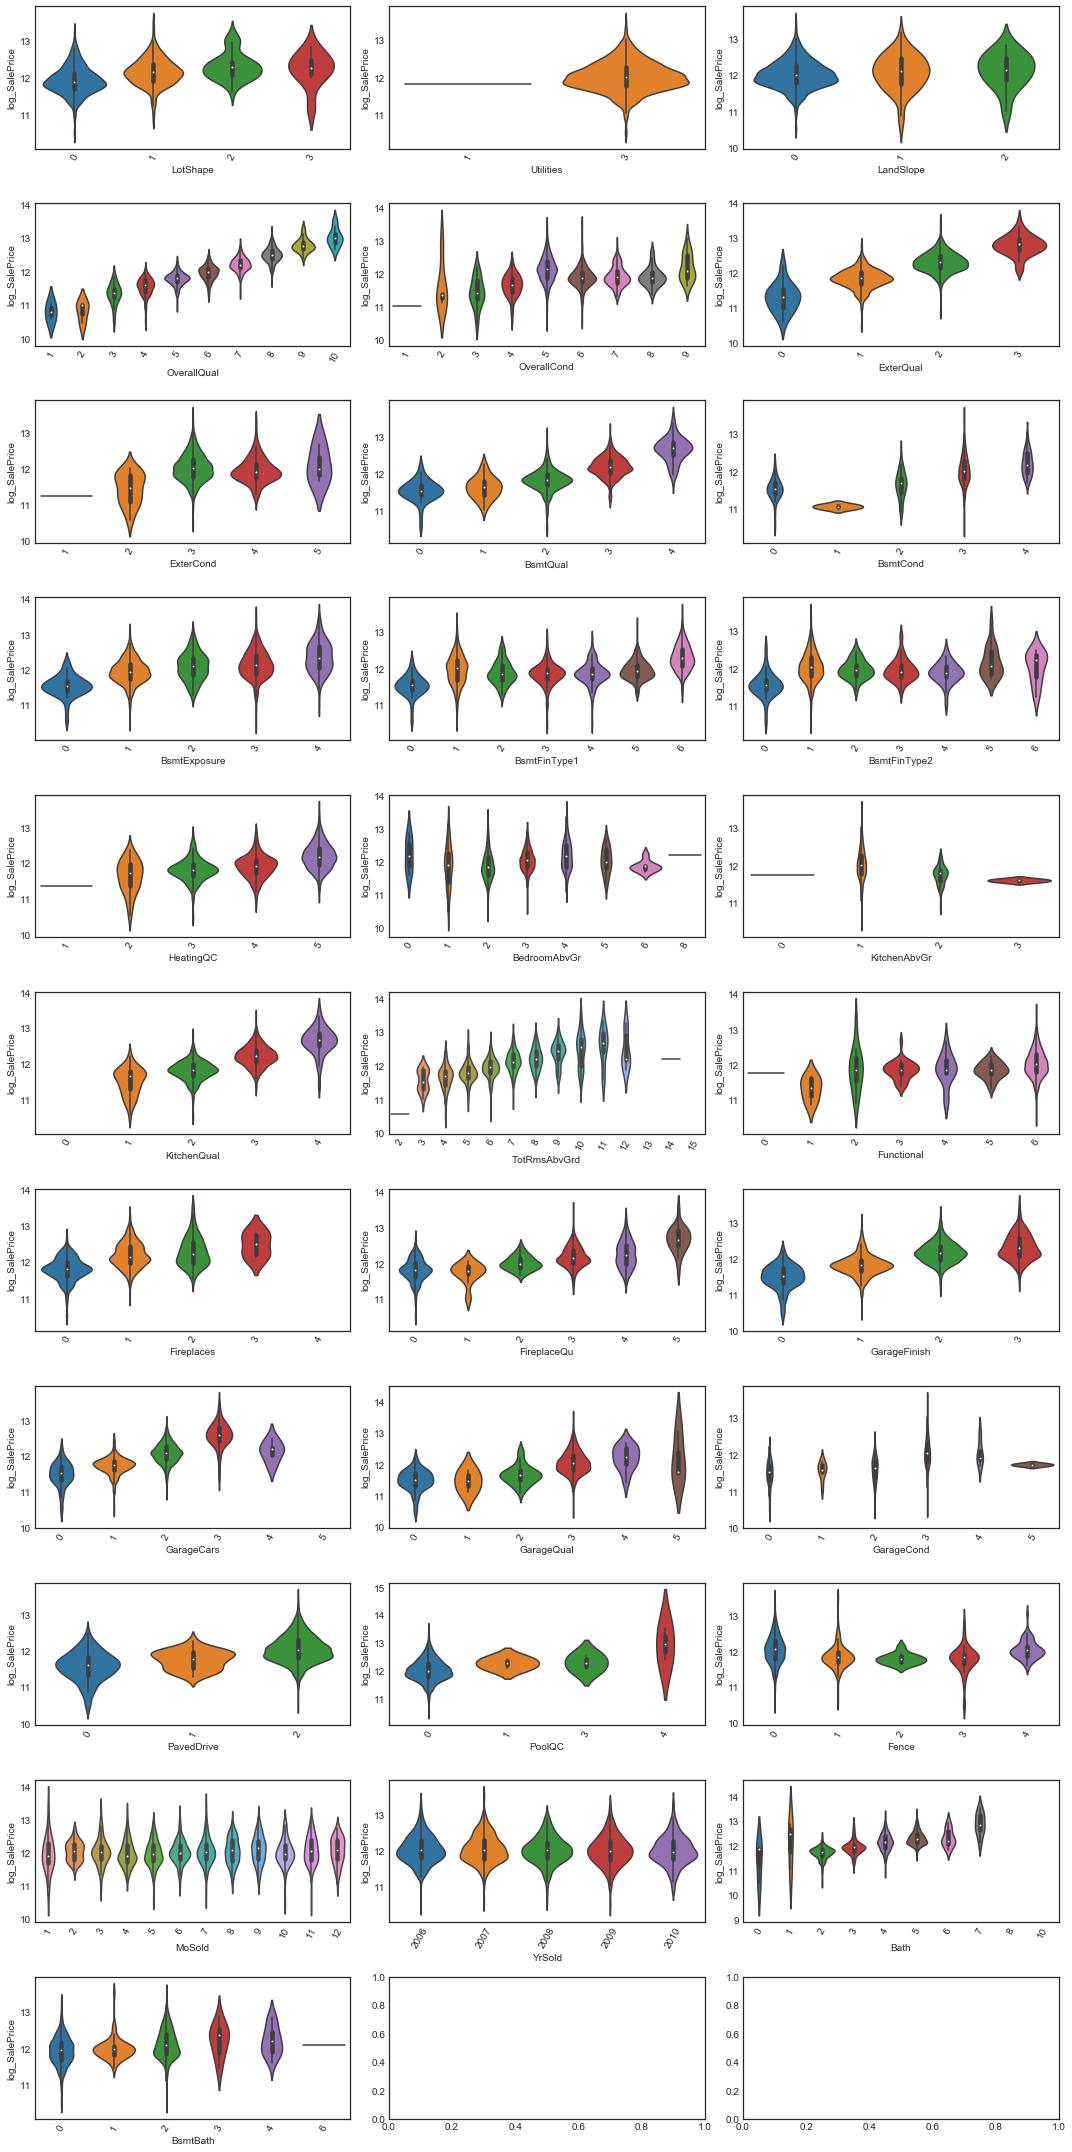

In [37]:
# violin plots of ordinals
plot_violin_plots(ords.data, 'log_SalePrice', 11, 3)

In [38]:
# plot dependence distance with log_SalePrice
D_dep_response(ords.data, 'log_SalePrice').sort_values(by='D').T

MoSold OverallQual TotRmsAbvGrd BsmtFinType1      Bath    YrSold  \
D  0.795577    0.821511      0.83499     0.859118  0.860505  0.877148   

  GarageCars  BsmtQual GarageFinish FireplaceQu  ...  BsmtCond GarageQual  \
D   0.879704  0.879858     0.886311    0.886812  ...  0.949305   0.951855   

  ExterCond GarageCond PavedDrive Functional LandSlope KitchenAbvGr    PoolQC  \
D  0.957094   0.959353   0.962894   0.965643  0.979514     0.981345  0.997317   

  Utilities  
D  0.999801  

[1 rows x 31 columns]

Again variables with unbalanced distributions (e.g. `PoolQc`, `Utilities`) tend to have high information distance, as do variables for which the distribution of `log_SalePrice` doesn't differ much across their classes (e.g. `BsmtHalfBath`, `PavedDrive`, `LandSlope`).

That `OverallQual` has high dependence isn't surprising, but perhaps `MoSold` having the lowest is.

#### Rank correlation hypothesis tests

One way of testing statistical dependence between ordered varialbes is using [rank correlations](https://en.wikipedia.org/wiki/Rank_correlation). Since they're relatively straightforward to calculate, we calculate three common ones and compare. We'll look at [Pearson's $\rho$](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman's $r_s$](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), and [Kendall's $\tau$](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

In [39]:
# rank correlation results as dataframes
rho_df = rank_hyp_test(ords, 'rho', ss.pearsonr)
r_s_df = rank_hyp_test(ords, 'r_s', ss.spearmanr)
tau_df = rank_hyp_test(ords, 'tau', ss.kendalltau)
rank_hyp_test_dfs = {'rho': rho_df, 'r_s': r_s_df, 'tau': tau_df}

# rank and sort by p-value of Pearson's rho
get_rank_corr_df(rank_hyp_test_dfs).drop(columns=['rho', 'r_s', 'tau']).sort_values(by='rho_p_val_rank')

rho_p_val  rho_p_val_rank      r_s_p_val  r_s_p_val_rank  \
OverallQual    0.000000e+00               1   0.000000e+00               1   
ExterQual     7.761033e-201               2  2.040959e-203               3   
GarageCars    3.307683e-199               3  2.382463e-207               2   
KitchenQual   2.324509e-190               4  3.122308e-193               6   
BsmtQual      5.427313e-175               5  2.488211e-197               4   
Bath          2.602357e-170               6  1.408554e-196               5   
GarageFinish  2.620057e-146               7  9.382754e-165               7   
FireplaceQu   3.528296e-114               8  7.777438e-110               8   
TotRmsAbvGrd  3.524836e-110               9  4.199477e-108               9   
Fireplaces     2.049485e-89              10  2.189811e-101              10   
HeatingQC      2.503143e-82              11   2.833473e-89              11   
GarageQual     1.143613e-46              12   1.501771e-43              13   
BsmtExposure   3.598521e-45              13   1.337016e-41              14   
GarageCond     5.806508e-45              14   1.512574e-40              15   
BsmtFinType1   1.544276e-39              15   2.791158e-46              12   
PavedDrive     1.174245e-32              16   9.055822e-28              17   
LotShape       3.682206e-29              17   3.397766e-36              16   
BsmtCond       1.302478e-26              18   1.100259e-25              18   
BsmtBath       4.581843e-20              19   9.941243e-18              20   
BedroomAbvGr   5.553622e-16              20   6.069682e-20              19   
KitchenAbvGr   1.568173e-08              21   2.543739e-10              22   
Functional     1.437417e-07              22   9.116464e-08              23   
Fence          2.386137e-05              23   4.477501e-13              21   
PoolQC         1.030024e-03              24   1.490013e-02              26   
MoSold         2.677357e-02              25   7.253421e-03              25   
ExterCond      5.869885e-02              26   6.460164e-01              31   
YrSold         1.550808e-01              27   2.543787e-01              29   
OverallCond    1.567476e-01              28   6.717184e-07              24   
LandSlope      1.671482e-01              29   7.277014e-02              27   
BsmtFinType2   5.861356e-01              30   1.246273e-01              28   
Utilities      6.304159e-01              31   5.249597e-01              30   

                  tau_p_val  tau_p_val_rank  
OverallQual   5.929359e-270               1  
ExterQual     1.272156e-159               4  
GarageCars    6.327182e-176               2  
KitchenQual   1.456887e-158               5  
BsmtQual      1.250445e-164               3  
Bath          1.958288e-157               6  
GarageFinish  2.217914e-140               7  
FireplaceQu    1.384314e-99               9  
TotRmsAbvGrd  5.527766e-104               8  
Fireplaces     5.443444e-88              10  
HeatingQC      5.700439e-81              11  
GarageQual     2.160589e-41              13  
BsmtExposure   1.843618e-40              14  
GarageCond     2.197488e-38              15  
BsmtFinType1   2.122343e-46              12  
PavedDrive     6.292790e-27              17  
LotShape       1.363538e-34              16  
BsmtCond       4.811484e-25              18  
BsmtBath       1.720179e-17              20  
BedroomAbvGr   2.027010e-20              19  
KitchenAbvGr   3.235206e-10              22  
Functional     9.253383e-08              23  
Fence          1.551382e-12              21  
PoolQC         1.492559e-02              26  
MoSold         6.503260e-03              25  
ExterCond      6.635896e-01              31  
YrSold         2.573829e-01              29  
OverallCond    1.787177e-07              24  
LandSlope      7.323031e-02              27  
BsmtFinType2   1.412702e-01              28  
Utilities      5.247749e-01              30

There is more or less good agreement of $p$-value rankings among the rank correlation hypothesis tests. In particular for a 95% significance level all three fail to reject the null for `MoSold`, `ExterCond`, `OverallCond`, `LandSlope`, `BsmtFinType2`, `Utilities` and `BsmtHalfBath`. Applying a stricter value of 99.9% significance, all three reject `PoolQC` as well.

It's important to recognize that rank correlation tests are measures of monotonicity (the tendency of variables to increase together and decrease together). They may fail to detect non-linear relationships that are not monotonic. In our particular case, `MoSold` had the highest statistical dependence with `log_SalePrice` among ordinal variables, but all three rank correlation tests reject a relationship between the two at 95\% significance.

## Quantitative variables

Finally we'll consider the quantitative variables, that is the continuous variables. In our cleaned dataframe these are the variables with `float64` dtype.

In [61]:
# dataframe of quantitative variables
quants = HPDataFramePlus(data=clean.data.select_dtypes('float64').drop(columns=['SalePrice']))
quants.data.head()

LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
      Id                                                              
train 1          65.0   8450.0     2003.0        2003.0       196.0   
      2          80.0   9600.0     1976.0        1976.0         0.0   
      3          68.0  11250.0     2001.0        2002.0       162.0   
      4          60.0   9550.0     1915.0        1970.0         0.0   
      5          84.0  14260.0     2000.0        2000.0       350.0   

          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  \
      Id                                                            ...   
train 1        706.0         0.0      150.0        856.0     856.0  ...   
      2        978.0         0.0      284.0       1262.0    1262.0  ...   
      3        486.0         0.0      434.0        920.0     920.0  ...   
      4        216.0         0.0      540.0        756.0     961.0  ...   
      5        655.0         0.0      490.0       1145.0    1145.0  ...   

          GrLivArea  GarageYrBlt  GarageArea  WoodDeckSF  OpenPorchSF  \
      Id                                                                
train 1      1710.0       2003.0       548.0         0.0         61.0   
      2      1262.0       1976.0       460.0       298.0          0.0   
      3      1786.0       2001.0       608.0         0.0         42.0   
      4      1717.0       1998.0       642.0         0.0         35.0   
      5      2198.0       2000.0       836.0       192.0         84.0   

          EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  
      Id                                                            
train 1             0.0        0.0          0.0       0.0      0.0  
      2             0.0        0.0          0.0       0.0      0.0  
      3             0.0        0.0          0.0       0.0      0.0  
      4           272.0        0.0          0.0       0.0      0.0  
      5             0.0        0.0          0.0       0.0      0.0  

[5 rows x 22 columns]

In [62]:
quants.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Data columns (total 22 columns):
LotFrontage      2916 non-null float64
LotArea          2916 non-null float64
YearBuilt        2916 non-null float64
YearRemodAdd     2916 non-null float64
MasVnrArea       2916 non-null float64
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtUnfSF        2916 non-null float64
TotalBsmtSF      2916 non-null float64
1stFlrSF         2916 non-null float64
2ndFlrSF         2916 non-null float64
LowQualFinSF     2916 non-null float64
GrLivArea        2916 non-null float64
GarageYrBlt      2916 non-null float64
GarageArea       2916 non-null float64
WoodDeckSF       2916 non-null float64
OpenPorchSF      2916 non-null float64
EnclosedPorch    2916 non-null float64
3SsnPorch        2916 non-null float64
ScreenPorch      2916 non-null float64
PoolArea         2916 non-null float64
MiscVal          2916 non-null float64
dtypes: float64(22

In [63]:
# print description of quantitative variables
quants.desc = desc
quants.print_desc(cols=quants.data.columns)

LotFrontage: Linear feet of street connected to property



LotArea: Lot size in square feet



YearBuilt: Original construction date



YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)



MasVnrArea: Masonry veneer area in square feet



BsmtFinSF1: Type 1 finished square feet



BsmtFinSF2: Type 2 finished square feet



BsmtUnfSF: Unfinished square feet of basement area



TotalBsmtSF: Total square feet of basement area



1stFlrSF: First Floor square feet



2ndFlrSF: Second floor square feet



LowQualFinSF: Low quality finished square feet (all floors)



GrLivArea: Above grade (ground) living area square feet



GarageYrBlt: Year garage was built



GarageArea: Size of garage in square feet



WoodDeckSF: Wood deck area in square feet



OpenPorchSF: Open porch area in square feet



EnclosedPorch: Enclosed porch area in square feet



3SsnPorch: Three season porch area in square feet



ScreenPorch: Screen porch area in square feet



PoolAre

In [64]:
quants.data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (train, 1) to (test, 2919)
Data columns (total 22 columns):
LotFrontage      2916 non-null float64
LotArea          2916 non-null float64
YearBuilt        2916 non-null float64
YearRemodAdd     2916 non-null float64
MasVnrArea       2916 non-null float64
BsmtFinSF1       2916 non-null float64
BsmtFinSF2       2916 non-null float64
BsmtUnfSF        2916 non-null float64
TotalBsmtSF      2916 non-null float64
1stFlrSF         2916 non-null float64
2ndFlrSF         2916 non-null float64
LowQualFinSF     2916 non-null float64
GrLivArea        2916 non-null float64
GarageYrBlt      2916 non-null float64
GarageArea       2916 non-null float64
WoodDeckSF       2916 non-null float64
OpenPorchSF      2916 non-null float64
EnclosedPorch    2916 non-null float64
3SsnPorch        2916 non-null float64
ScreenPorch      2916 non-null float64
PoolArea         2916 non-null float64
MiscVal          2916 non-null float64
dtypes: float64(22

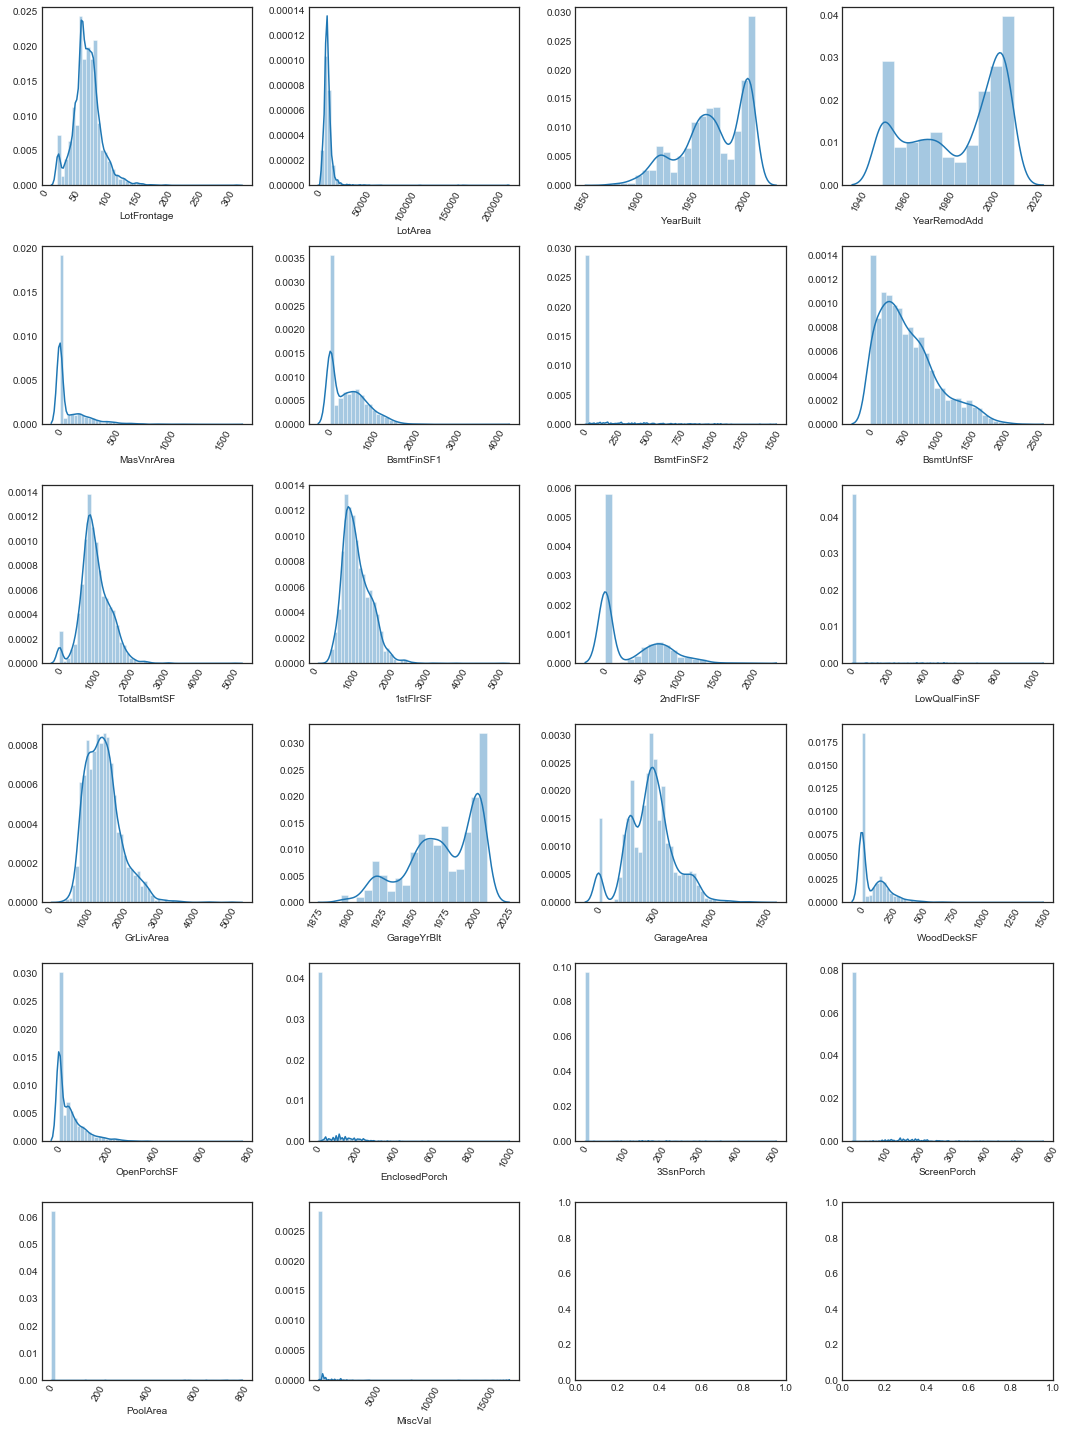

In [65]:
# plot distributions of quantitative variables
plot_cont_dists(nrows=6, ncols=4, data=quants.data)

Most of the variables are highly positively skewed

In [66]:
quants.data.skew()

LotFrontage       1.005483
LotArea          13.269377
YearBuilt        -0.600024
YearRemodAdd     -0.449893
MasVnrArea        2.621143
BsmtFinSF1        0.982465
BsmtFinSF2        4.145816
BsmtUnfSF         0.919998
TotalBsmtSF       0.677494
1stFlrSF          1.259407
2ndFlrSF          0.861482
LowQualFinSF     12.088646
GrLivArea         1.069506
GarageYrBlt      -0.651556
GarageArea        0.219101
WoodDeckSF        1.847119
OpenPorchSF       2.533111
EnclosedPorch     4.003630
3SsnPorch        11.375940
ScreenPorch       3.946335
PoolArea         17.694707
MiscVal          21.947201
dtype: float64

Some of the quantitative variables appear to be multimodal. For quite a few, this is due to a large peak at zero, and for some it's clear that zero is being used as a stand-in for a null value (for example, `PoolArea` = 0 if the house has no pool). We'll look at which variables have a high peak at zero

We note that many of these variables have long right tails, so logarithmic scales may be more appropriate for these.

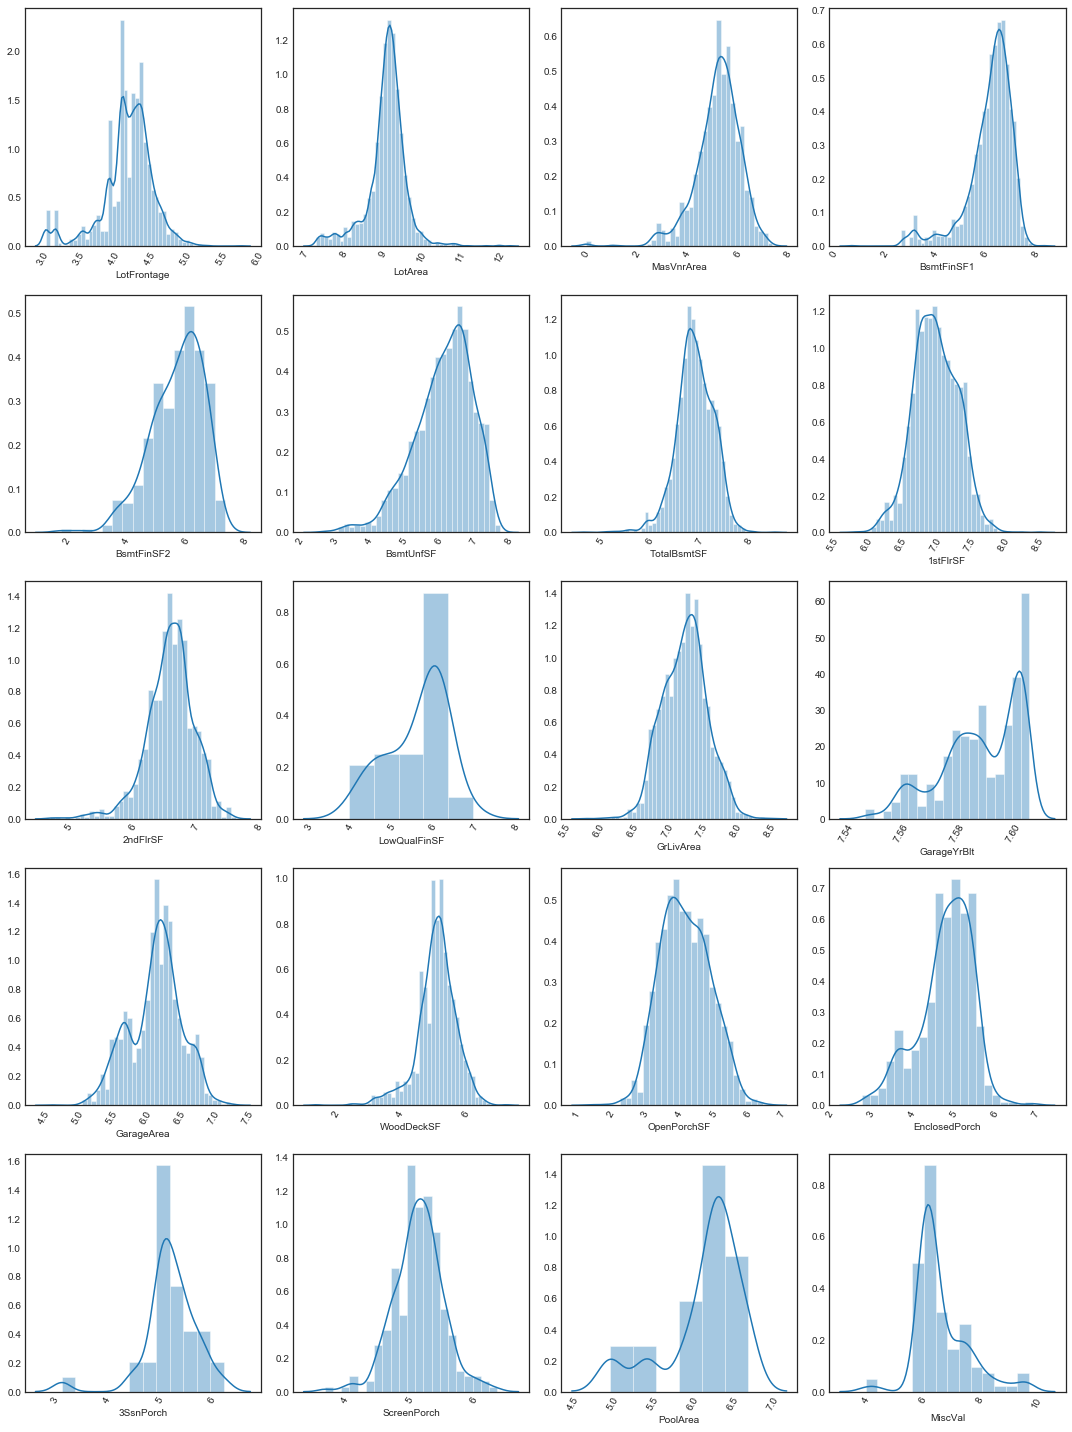

In [67]:
# plot distributions of logarithms of all nonzero values of quantitative variables
log_cols = quants.data.columns.drop(['YearBuilt', 'YearRemodAdd'])
plot_log_cont_dists(nrows=5, ncols=4, data=quants.data, log_cols=log_cols)

### Relationships among quantitative variables

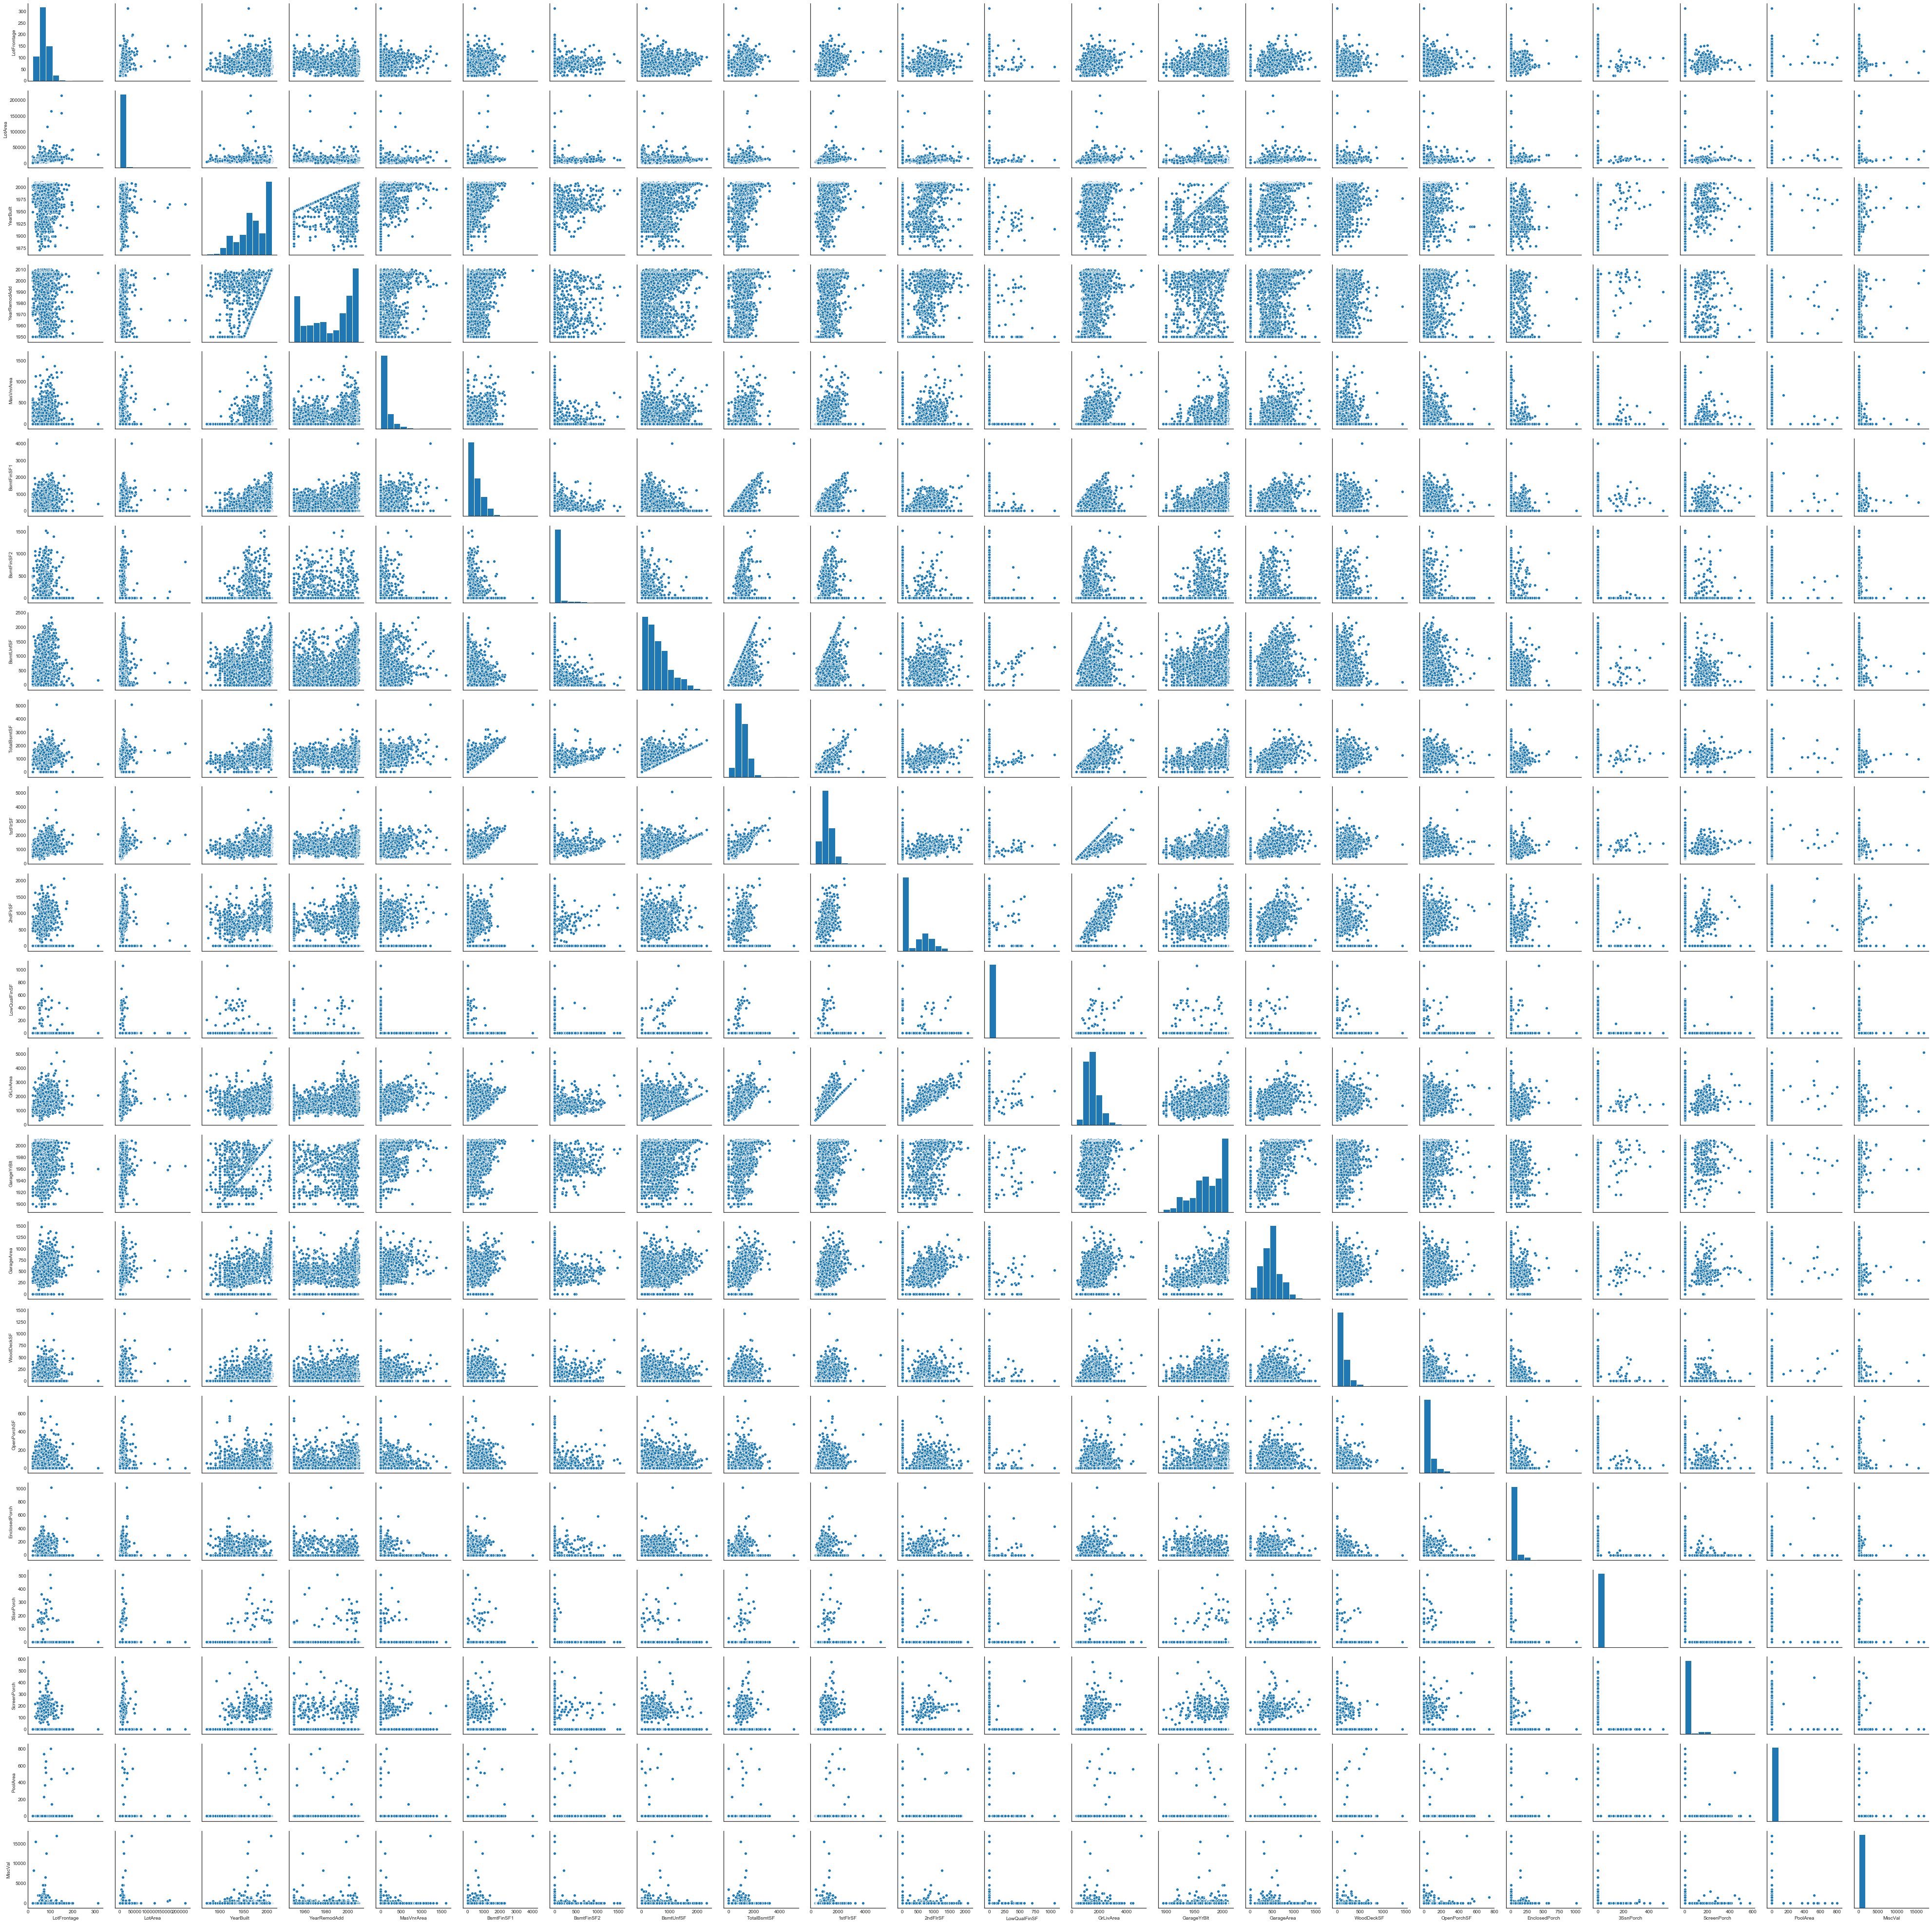

In [46]:
# scatterplots of quantitative variables
sns.pairplot(quants.data)

While pairplots can be helpful, this one is a bit too big to be of much use, although it may inform later methods of detecting relationships.

Some things do stand out:

- There appear to be regions of exclusion for certain pairs of variables, probably due to impossible values. For example, `YrRemodAdd` is never greater than `YrBuilt`. 

- Many of the distributions are very concentrated. `LotArea`, `BsmtFinSF2`, `LowQualFinSF`, `EnclosedPorch`, `3SsnPorch` all stand out as extremely concentrated.


Now we'll look at dependencies among the quantitative variables

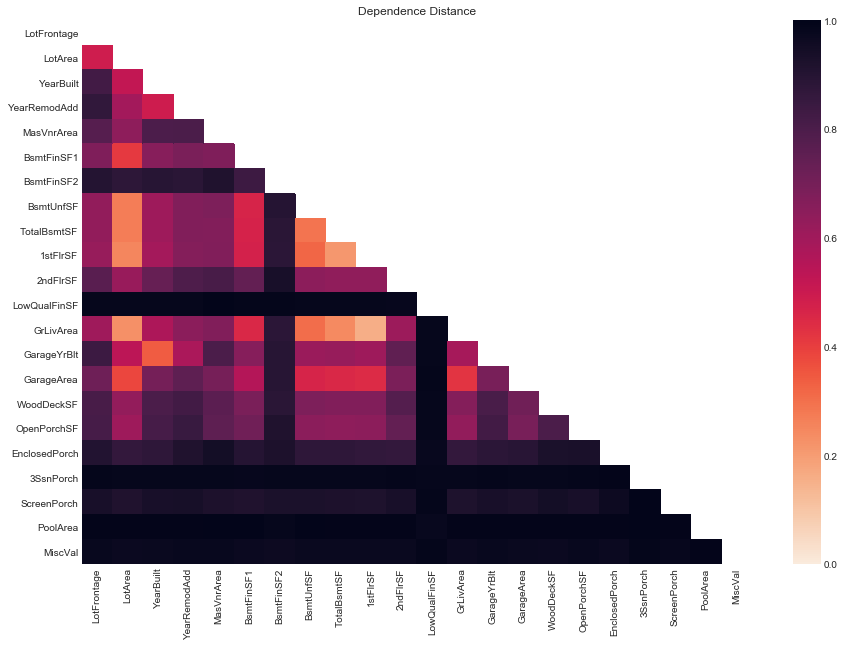

In [68]:
# plot dependence distances of quantitative variables
quants_D_dep_df = D_dep(quants.data)
plot_D_dep(D_dep_df=quants_D_dep_df)

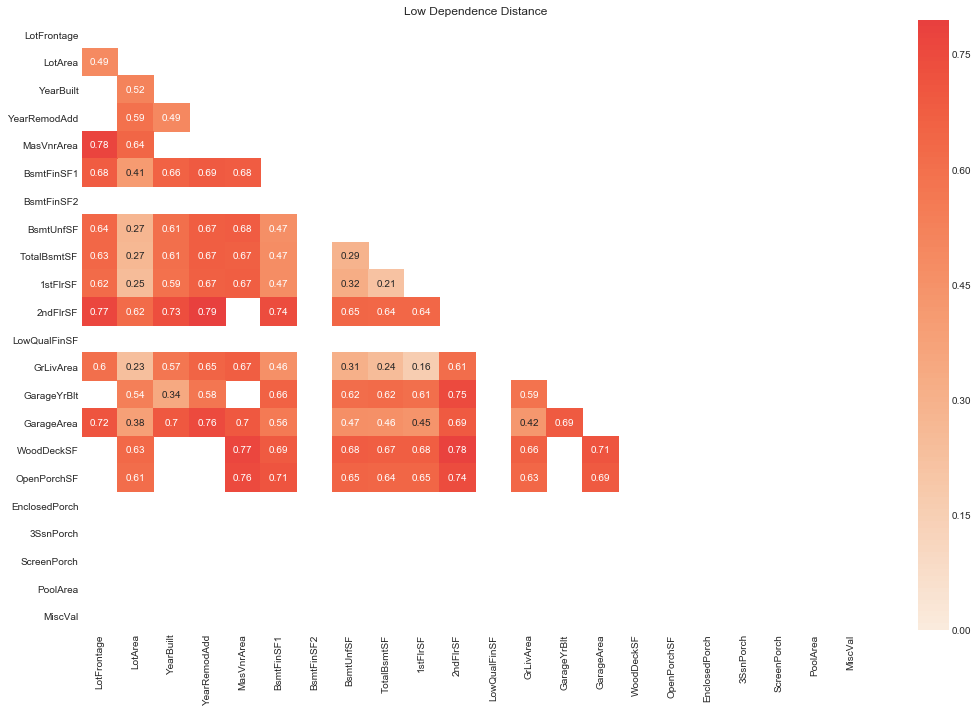

In [70]:
# plot lower dependence distances of quantitative variables
plot_low_D_dep(D_dep_df=quants_D_dep_df, D_threshold=0.8)

In [75]:
# display pairs of quantitatives with low dependence distance
rank_pairs_by_D(D_dep_df=quants_D_dep_df, D_threshold=0.8).head(10)

var1         var2         D
1      1stFlrSF    GrLivArea  0.158882
2   TotalBsmtSF     1stFlrSF  0.213738
3       LotArea    GrLivArea  0.227010
4   TotalBsmtSF    GrLivArea  0.242833
5       LotArea     1stFlrSF  0.250292
6       LotArea  TotalBsmtSF  0.269834
7       LotArea    BsmtUnfSF  0.273087
8     BsmtUnfSF  TotalBsmtSF  0.292260
9     BsmtUnfSF    GrLivArea  0.307987
10    BsmtUnfSF     1stFlrSF  0.320845

Compared to quantitative and ordinal variables pairs, pairs of quantitative variables are showing much higher dependencies (lower dependence distances) overall. For many of these pairs , the high dependence makes sense given both variables are measuring very similar areas, for example, `1stFlrSF`, `GrLivArea` and `TotalBsmtSF`.

We expect that Pearsons' $rho$ (i.e. correlation/linear dependence) of these variables should be high as well.

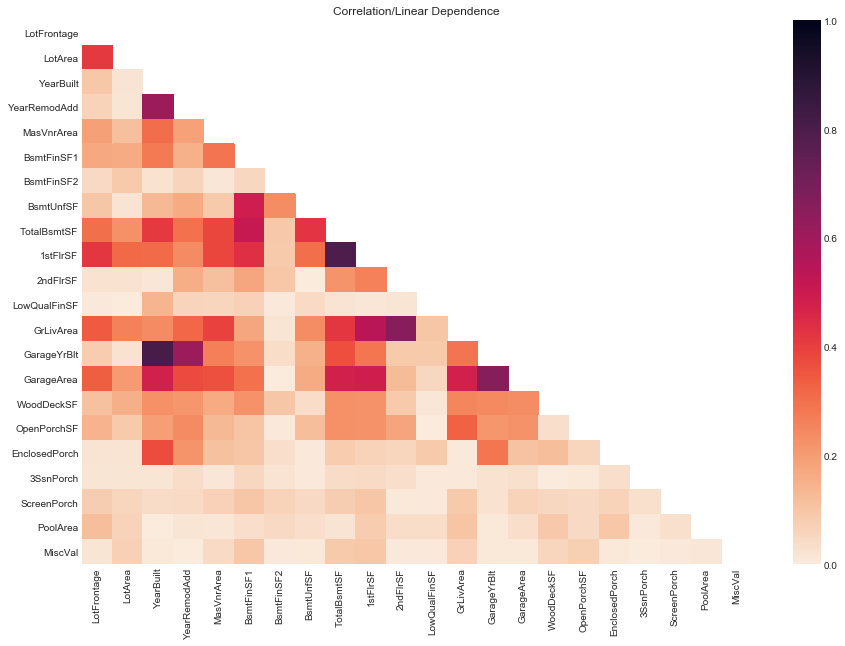

In [76]:
# plot pearson's correlation for quantitative variables
plot_corr(quants_data=quants.data)

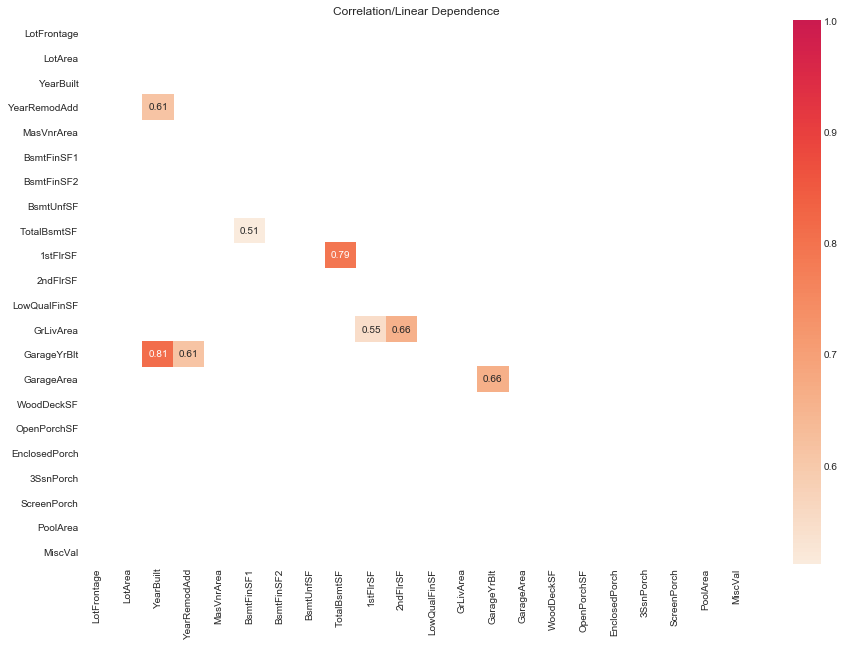

In [77]:
# plot high absolute value of correlations of quantiatives
plot_high_corr(quants_data=quants.data, abs_corr_threshold=0.5)

In [78]:
# rank pairs of quantitatives by absolute values of correlation
rank_pairs_by_abs_corr_df = rank_pairs_by_abs_corr(quants_data=quants.data, abs_corr_threshold=0.5)
rank_pairs_by_abs_corr_df

var1          var2  abs_corr
1    BsmtFinSF1   TotalBsmtSF  0.511258
2      1stFlrSF     GrLivArea  0.546383
3     YearBuilt  YearRemodAdd  0.612023
4  YearRemodAdd   GarageYrBlt  0.612872
5      2ndFlrSF     GrLivArea  0.658420
6   GarageYrBlt    GarageArea  0.661785
7   TotalBsmtSF      1stFlrSF  0.793482
8     YearBuilt   GarageYrBlt  0.810713

### Relationships between quantitative variables and `SalePrice`

In [79]:
# add log_SalePrice to quantitatives dataframe
quants.data['log_SalePrice'] = np.log(clean.data['SalePrice'])
quants.data['log_SalePrice']

       Id  
train  1       12.247694
       2       12.109011
       3       12.317167
       4       11.849398
       5       12.429216
                 ...    
test   2915          NaN
       2916          NaN
       2917          NaN
       2918          NaN
       2919          NaN
Name: log_SalePrice, Length: 2916, dtype: float64

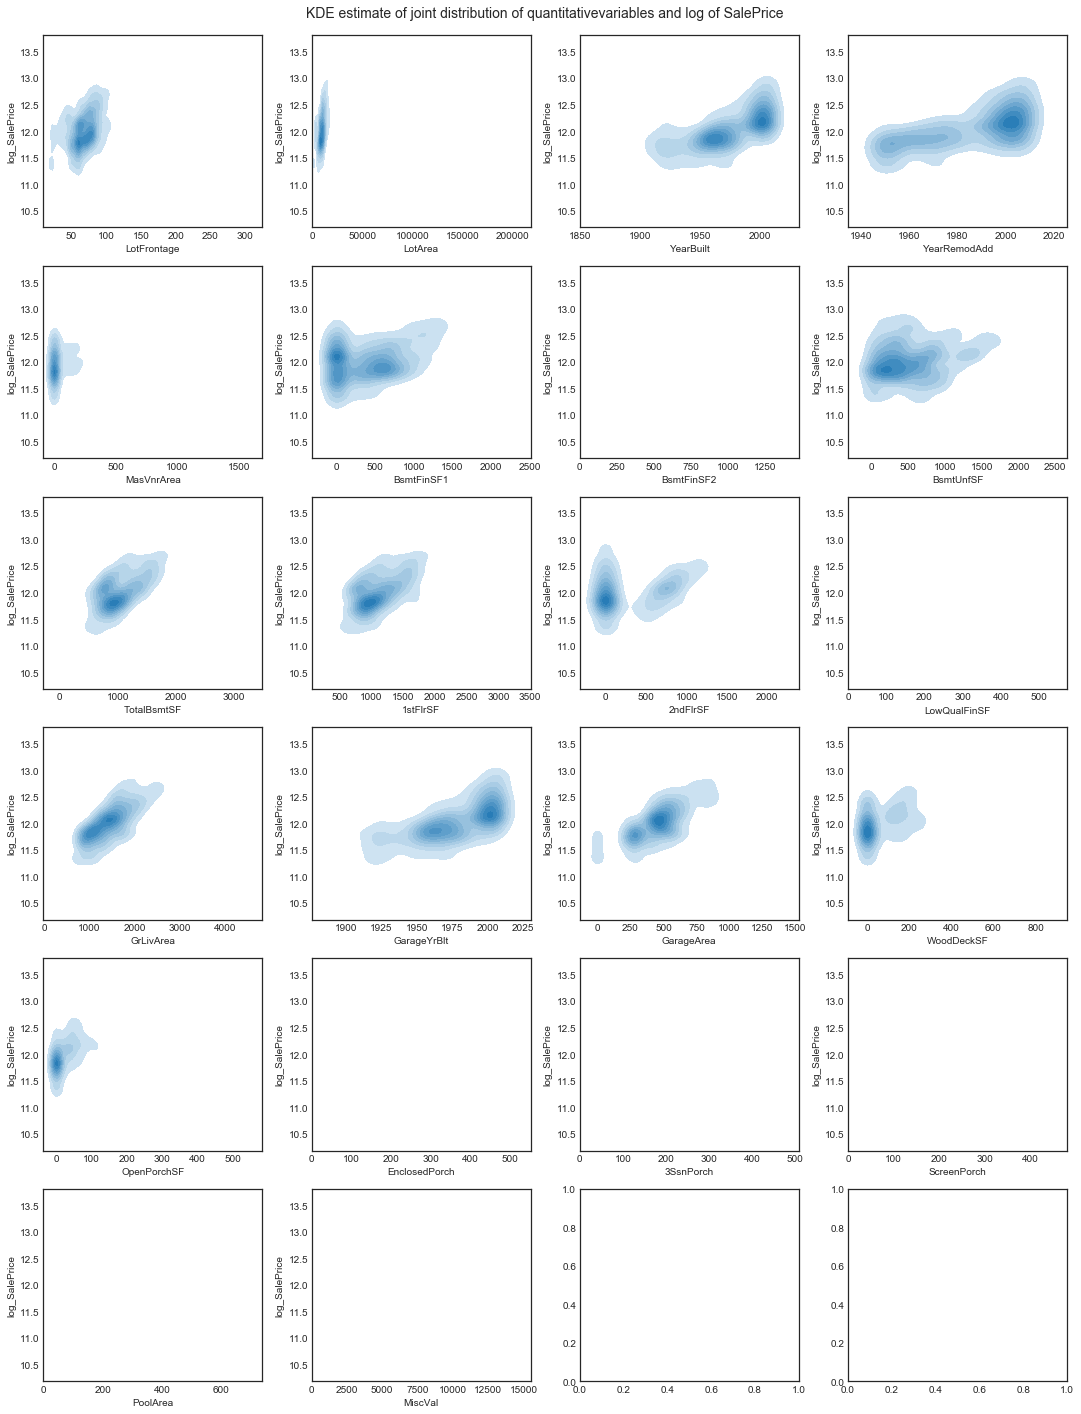

In [80]:
# plot joint distributions of quantitative variables and log of sale price
plot_joint_dists_with_response(nrows=6, ncols=4, quants_data=quants.data, response='log_SalePrice')

The distribution of some of the variables appears to be problematic for `seaborn` to fit a joint kernel density estimate. We'll look at scatterplots instead

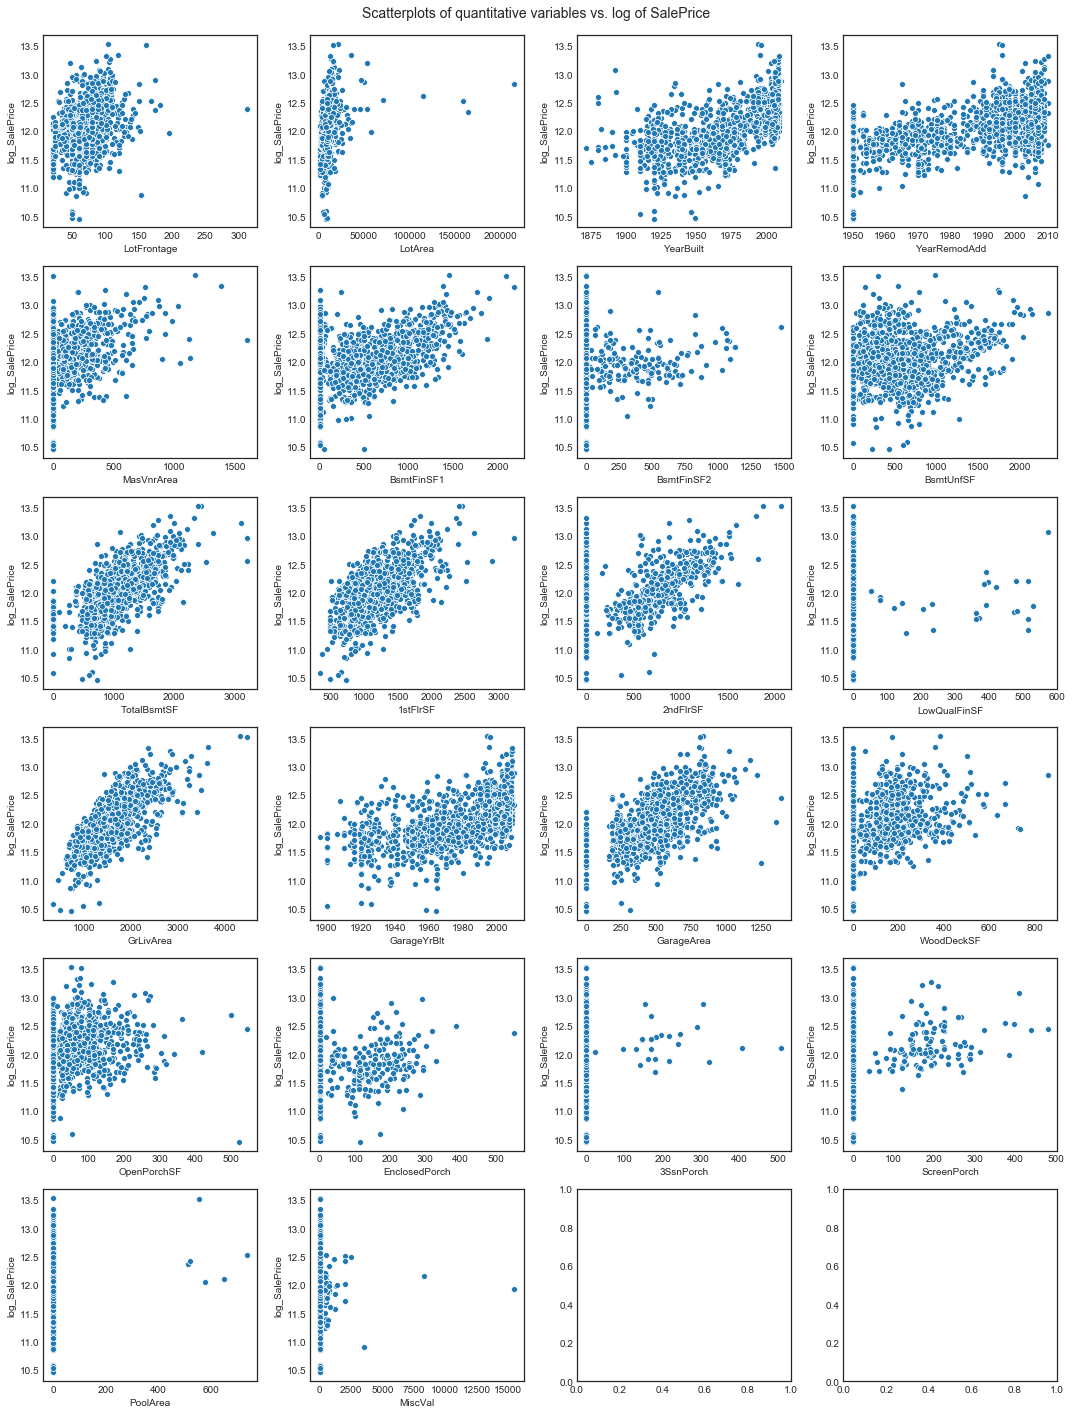

In [56]:
# scatterplots of quantitative variables and log of sale price
plot_scatter_with_response(nrows=6, ncols=4, quants_data=quants.data, response='log_SalePrice')

Now will look at scatterplots of log transformations of the quantitive variables vs. `log_SalePrice`

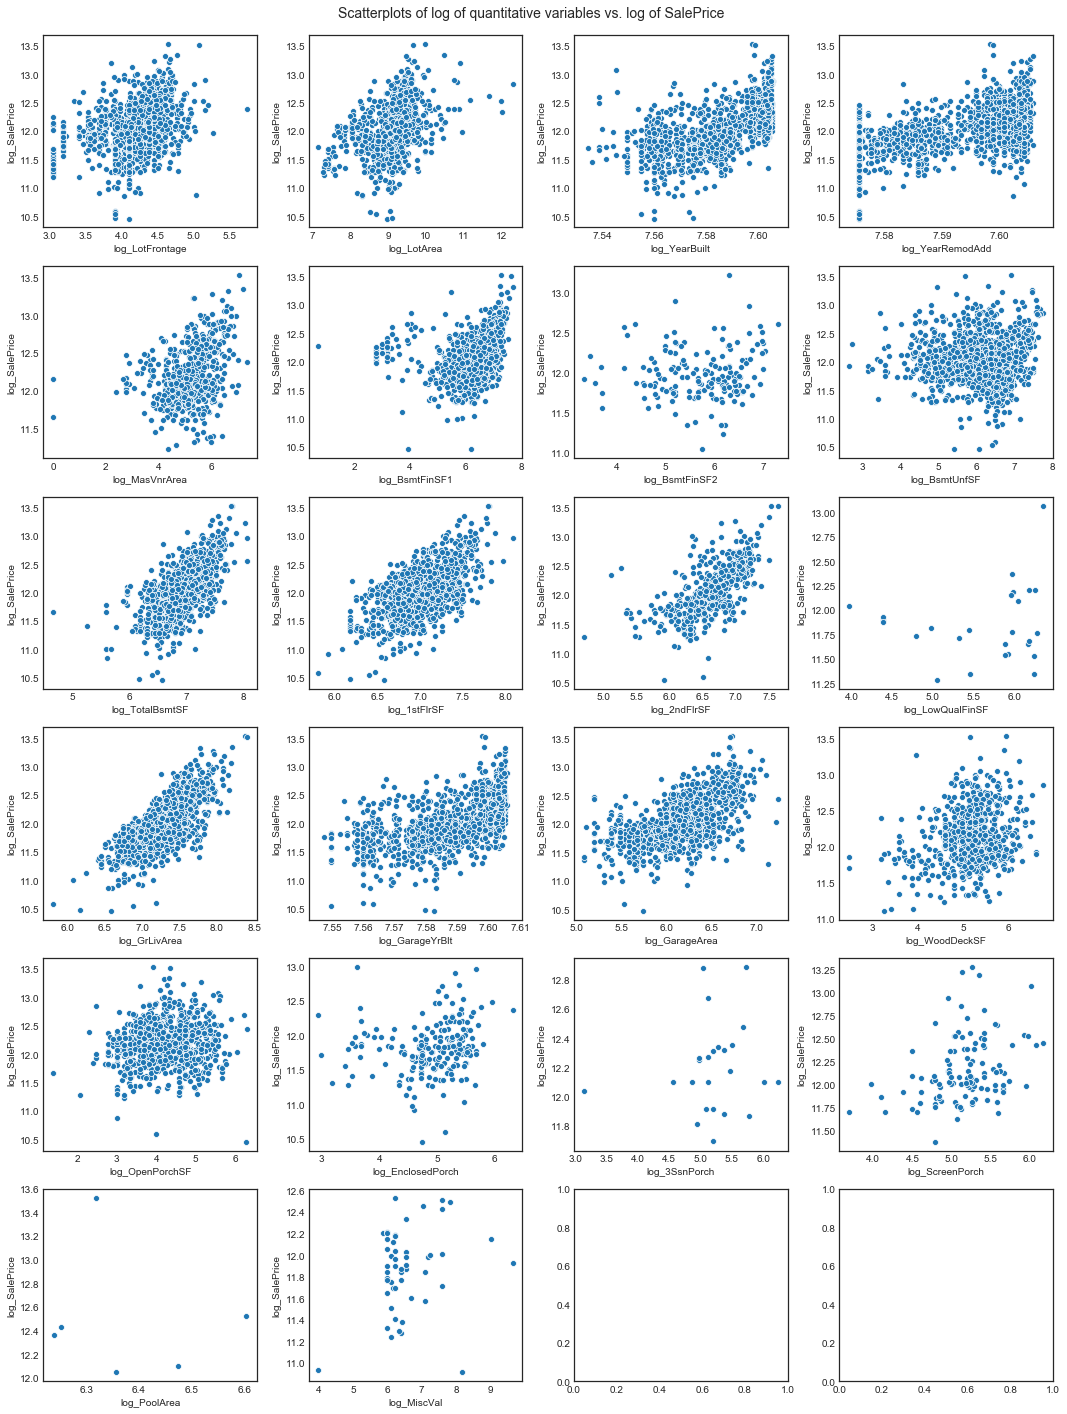

In [57]:
# scatterplots of log of nonzero values of quantitative variables and log of sale price
plot_log_scatter_with_response(nrows=6, ncols=4, quants_data=quants.data, response='log_SalePrice')

In [81]:
# rank dependence distance of quantiatives with log_SalePrice
D_dep_response(data=quants.data, response='log_SalePrice').sort_values(by='D').T

LotArea GrLivArea  1stFlrSF BsmtUnfSF TotalBsmtSF GarageArea BsmtFinSF1  \
D  0.166598  0.216601  0.243486  0.259179    0.266558   0.390699    0.41101   

  YearBuilt GarageYrBlt LotFrontage  ... YearRemodAdd WoodDeckSF MasVnrArea  \
D  0.549621    0.559745    0.580649  ...     0.627967   0.632256   0.647084   

  EnclosedPorch BsmtFinSF2 ScreenPorch   MiscVal LowQualFinSF 3SsnPorch  \
D      0.854684   0.875006    0.913641  0.968622     0.985514   0.98756   

   PoolArea  
D  0.995242  

[1 rows x 22 columns]

Considering the scatterplots and taking into account the dependence distance $D$, we see that some quantitative variables appear are likely to be less helpful in predicting `SalePrice`. Of these, `EnclosedPorch`, `BsmtFinSF2`, `ScreenPorch`, `MiscVal`, `LowQualFinSF`, `3SSnPorch`, and `PoolArea` stand out (all have $D \gt 0.8$)